In [1]:
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/PhD/Schrodinger_deep_learning

/content/gdrive/My Drive/Colab Notebooks/PhD/Schrodinger_deep_learning


In [3]:
%tensorflow_version 2.x

# Integrating the Schrödinger equation with Deep Learning in 2D

This notebook extends the work developed in *Random potentials* by using two-dimensional potentials. In this case, we will train a neural network to  find the stationary states of the Time-Independent Schrödinger equation in 2D:

$$
\Big( - \frac{\hbar^2}{2m} (\frac{\partial^2}{\partial x^2} + \frac{\partial^2}{\partial y^2}) + V(x,y) \Big) \phi_n(x,y) = E_n \phi_n(x,y) 
$$

Where $\hbar$ is the reduced Plank constant, $m$ is the mass of the particle, $V(x,y)$ is the potential under which the particle evolves. $\phi_n(x,y)$ is the $n$-th stationary state of the quantum system, with energy $E_n$. The subscrit $n$ can be discrete ($n \in \mathbb{Z}$) or continuous ($n \in \mathbb{R}$).

The stationary wave functions $\phi_n(x,y)$ have a trivial time evolution:

$$
\phi_n(x,y,t) = \phi_n(x,y) e^{-i \frac{E_n}{\hbar}t}
$$

They form a basis of the Hilbert Space of the Hamiltonian of the system

$$
\hat{H} = \frac{\hat{p}^2}{2m} + V(\hat{x,y})
$$

Therefore, the evolution of an arbitrary state of the system $\psi(x,t)$ will be given by:

$$
\psi(x,y,t) = \sum_k c_k \phi_k(x,y) e^{-i \frac{E_k}{\hbar}t} 
$$

Where $c_k$ are linear coefficients and the sum over $k$ can be either discrete or continuous (an integral). The modulus square of the coefficients $|c_k|^2$ represents the probability of being in the $k$-th excited state. 



# Variational method with the H.O basis in 2D

In this section we extend the variational method using the H.O basis to a two-dimensional system. Thus, we onlly focus on the differences between the 1D and 2D system. For more information about the Variational method, refer to the notebook *Random Potentials*. 


### The H.O basis in 2D


We choose as a basis of $\mathcal{H}$ the eigenfunctions of the Harmonic Oscillator with $m=1$, $\hbar=1$ and $\omega=1$ in 2D:

$$
\hat{H} = \frac{\hat{p}^2}{2m} + \frac{1}{2}m\omega^2(x^2 + y^2)
$$

Notice that the angular frequency is the same for the two dimensions. Therefore, there is a degeneracy in the energies. Since the H.O is not coupled, the S.E is separable, and thus the eigenfunctions are the product of the 1D eigenfunctions in both axis:

$$
\phi_{n_x, n_y}(x) = \frac{1}{\sqrt{n_x!2^{n_x} \sqrt{\pi}}}\frac{1}{\sqrt{n_y!2^{n_y} \sqrt{\pi}}} e^{-x^2/2}e^{-y^2/2} H_{n_x}(x)H_{n_y}(x)
$$

Where $H_n(x)$ is the $n$th Hermite polynomial. Notice that $n_x$ is the energy level in direction $x$ and $n_y$ is the energy level in direction $y$. 

The energy of an eigenstate with energy levels $n_x$ and $n_y$ is:

$$
E_{n_x, n_y} = \hbar \omega(n_x + n_y +1) = E_{n_x+n_y}
$$

Thus, any two pairs $(n_x, n_y)$ with the same sum $n_x + n_y$ will have the same energy. Therefore, it is not clear how to order the energy levels. Here we define a (bijective) order $n(n_x, n_y)$ so that we can order the energy levels and the eigenfunctions. 

The order $n(n_x,n_y)$ at each energy is chosen by increasing $n_x$ until it reaches the energy level. Meanwhile, the value of $n_y$ is chosen to maintain the sum $n_x+n_y$. An example is shown in the table below:

| $n$ | $n_x$ | $n_y$ | $n_x$+$n_y$ |
|-----|-------|-------|-----------|
| 0   |  0    |  0    |   0       |
| 1   |  0    |  1    |   1       |
| 2   |  1    |  0    |   1       |
| 3   |  0    |  2    |   2       |
| 4   |  1    |  1    |   2       |
| 5   |  2    |  0    |   2       |
| 6   |  0    |  3    |   3       |
| 7   |  1    |  2    |   3       |
| 8   |  2    |  1    |   3       |
| 9   |  3    |  0    |   3       |


It is then straightforward to find $n$ given $n_x$ and $n_y$:

$$
n = n_x  + \sum_{m=0}^{n_x + n_y -1} m+1
$$

Since the order is bijective, we can also find $n_x$ and $n_y$ given $n$.
 In order to do so, we will sum $\sum_m m+1$ until $\sum_m m+1\geq n$. The number of times we have summed will be $n_x + n_y -1$ and the difference between the sum and $n$ will be $n_x$. We define the functions to get $n(n_x, n_y)$ and $n_x,n_y(n)$ respectively.





In [4]:
#@title Code to calculate the order of eigenstates
#@markdown Double click to see the code

import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema


def get_nx_ny(n):
  s=0
  i=-1 
  while s<n:
    i+=1
    s+=i+1
  if s==n:
    N=i+1
  else:
    s-=i+1
    N=i # N= nx+ny
  nx = n-s
  ny = N-nx
  return nx,ny


def get_n(nx,ny):
  return np.sum([i+1 for i in range(nx+ny)]) + nx

Now that we have defined an order of the wavefunctions, we can write $\phi_{n_x,n_y}(x,y) = \phi_n(x,y)$ where $n(n_x,n_y)$. Since $\{\phi_n(x,y)\}_n$ form a basis of $\mathcal{H}$, we can write any wavefunction $\psi(x,y)$ as a linear combination of the eigenfunctions:

$$
\psi(x,y) = \sum_{n=0}^\infty a_n \phi_n(x,y)
$$

Thus, the mean energy of $psi$ is

$$
<H> = <\psi|\hat{H}|\psi> = \int_{-\infty}^\infty\int_{-\infty}^\infty \Big(\sum_{n=0}^\infty a_n \phi_n(x,y)\Big) \hat{H} \Big(\sum_{m=0}^\infty a_m \phi_m(x,y)\Big) dx dy=\\
\sum_{n=0}^\infty \sum_{m=0}^\infty a_n a_m\int_{-\infty}^\infty \int_{-\infty}^\infty \phi_n(x,y) H(x,y) \phi_m(x,y)dx = \sum_{n=0}^\infty \sum_{m=0}^\infty a_n a_m C_{nm}
$$

where

$$
C_{nm} = \int_{-\infty}^\infty \int_{-\infty}^\infty A_n e^{-x^2/2} H_{n_x}(x)e^{-y^2/2} H_{n_y}(y) \Big(-\frac{1}{2} \frac{\partial^2}{\partial x^2} -\frac{1}{2} \frac{\partial^2}{\partial y^2} + V(x,y) \Big) A_m e^{-x^2/2}e^{-y^2/2} H_{m_x}(x) H_{m_y}(y) dx dy, \quad A_n = \frac{1}{\sqrt{n_x!2^{n_x} \sqrt{\pi}}}\frac{1}{\sqrt{n_y!2^{n_y} \sqrt{\pi}}}
$$

In order to find a good estimation of the ground energy, we will generate a finite basis of H.O eigenstates $\{\phi_n\}_{n=0}^N$ and then find the coefficients $\{a_n\}$ which minimize the mean energy $<H>$. 

## Calculating $C_{nm}$

Given the potential:

$$
V(x,y) = \sum_{i=1}^k \sum_{j=0}^k \alpha_{ij} x^i y^j
$$

Recall that:

$$
\frac{\partial^2}{\partial x^2}(H_m(x) e^{-x^2/2} ) = e^{-x^2/2}\Big((x^2-1) H_m(x) - 4mx H_{m-1}(x) + 4m(m-1)H_{m-2}(x)\Big) := e^{-x^2/2} P_m(x)
$$

Then, the expression of $C_{nm}$ becomes:

$$
C_{nm} = A_n A_m \Big( - \frac{1}{2} \int_{-\infty}^\infty e^{-y^2} H_{n_y}(y) H_{m_y}(y) dy\int_{-\infty}^\infty  H_{n_x}(x) P_{m_x}(x) e^{-x^2} dx - \frac{1}{2} \int_{-\infty}^\infty e^{-x^2} H_{n_x}(y) H_{m_x}(x) dx\int_{-\infty}^\infty  H_{n_y}(y) P_{m_y}(y) e^{-y^2} dy + \int_{-\infty}^\infty \int_{-\infty}^\infty e^{-x^2-y^2} H_{n_x}(x)H_{n_y}(y)H_{m_x}(x)H_{m_y}(y)V(x,y) dxdy\Big) = \\
A_nA_m\Big( \sqrt{\pi}2^{n_y}n_y! \delta_{n_ym_y}I_P(n_x,m_x) + \sqrt{\pi}2^{n_x}n_x! \delta_{n_xm_x}I_P(n_y,m_y) + \sum_{i=0}^k \sum_{j=0}^k \alpha_{ij} I(n_x, m_x, i)I(n_y,m_i,j) \Big)
$$

Where $I_P(n,m)$ is:

$$
I_P(n,m) = - \frac{1}{2} I(n,m,2) + 1/2 I(n,m,0) + 2mI(n,m-1,1) - 2m(m-1)I(n, m-2, 0)
$$

And remember that

$$
I(n,m,r) = \int_{-\infty}^\infty x^r e^{-x^2} H_n(x) H_m(x) dx
$$




## Code

In the following cell we define a class which calculates the ground state energy and wavefunction of a potential of the form:

$$
V(x,y) = \sum_{i=1}^k \sum_{j=1}^k \alpha_{ij} x^i y^j
$$

The calculation is analytical (by using the Hermite integrals). This class generates random values of $\vec{\alpha}$ following a uniform distribution between $\vec{\alpha}_{min}$ and $\vec{\alpha}_{max}$. Then it calculates the $n_{state}$-th excited state for these potentials. It returns the energy of such states, the coefficients $\{a_n\}$, the potentials $V(x,y)$ and the wavefunctions $\psi(x,y) = \sum_{n=0}^N a_n \phi_n(x,y)$. 

In [5]:
#@title Class to find eigenstates using the H.O basis
#@markdown Double click to see the code
import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema

class eigen_state_potential2D:

  def __init__(self, alpha_min=None, alpha_max=None, N=10):
    '''
    Class to generate data (V(x) and phi(x) ground state) for potentials of the form
    V(x) = sum_i alpha_i x^i, using the H.O basis
    Args:
      alpha_min: vector of length N, with the minimum value of the coefficients alpha
      alpha_max: vector of length N, with the maximum value of the coefficients alpha
      the values of alpha will be randomly distributed in [alpha_min, alpha_max]
    '''
    if len(alpha_min)!=len(alpha_max):
      print("Error. Inconsisten shapes")
    self.alpha_min = np.array(alpha_min)
    self.alpha_max = np.array(alpha_max)
    self.N = N # Length of H.O basis
    self.k = len(alpha_min) #Number of alphas for V(x)

  def I_nmr(self,n,m,r):
    '''
    Calculates the value of the integral of the Hermitte polynomials
    Args:
      n (int): n of I(n,m,r)
      m (int): m of I(n,m,r)
      r (int): r of I(n,m,r)
    Returns:
      I(n,m,r)
    '''
    if r<0 or n<0 or m<0:
      return 0
    if r==0:
      if n==m:
        return np.sqrt(np.pi)*2**n*factorial(n)
      else:
        return 0
    return 1./2*self.I_nmr(n+1,m,r-1) + n*self.I_nmr(n-1,m,r-1)


  def int_P(self,n,m):
    I1 = -1/2*self.I_nmr(n,m,2)
    I2 = 1/2*self.I_nmr(n,m,0)
    I3 = 2*m*self.I_nmr(n,m-1,1)
    I4 = -2*m*(m-1)*self.I_nmr(n, m-2,0)
    return I1 + I2 + I3 + I4


  def C_nm(self,n,m, alphas):
    '''
    Calculates the coefficient C_{nm} for the potential V(x,y) = \sum_i \sum_j alpha[i,j]x^iy^j
    Args:
      n (int): n of C_nm
      m (int): m of C_nm
      alphas (np.array): size kxk. Coefficients of the potential V(x,y)
    Returns:
      C_{nm}
    '''
    # Given n and m find nx, ny, mx, my
    nx, ny = get_nx_ny(n)
    mx, my = get_nx_ny(m)

    # Find the normalization constants
    anx = np.sqrt(np.pi)*factorial(nx)*2**nx
    any = np.sqrt(np.pi)*factorial(ny)*2**ny
    amx = np.sqrt(np.pi)*factorial(mx)*2**mx
    amy = np.sqrt(np.pi)*factorial(my)*2**my
    A = 1./np.sqrt(anx*any*amx*amy)

    # Calculate integrals
    #Ix
    if ny==my:
      Ix = any*self.int_P(nx,mx)
    else:
      Ix = 0
    #Iy
    if nx==mx:
      Iy = anx*self.int_P(ny,my)
    else:
      Iy = 0
    #Iv
    Iv = 0
    for i in range(alphas.shape[0]):
      for j in range(alphas.shape[1]):
        Iv+=alphas[i,j]*self.I_nmr(nx,mx,i)*self.I_nmr(ny,my,j)
    return A*(Ix+Iy+Iv)

  def find_eigen_state(self,alphas, n_state=0):
    '''
    Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
    Args:
      alphas(np array): size kxk. Coefficients of the potential V(x)
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E_a (float): Energy of the ground state for potential V
      a (np.array): size N. Coefficients in the basis of the H.O potential
    '''
    N = self.N
    # 0. Generate matrix of C_nm
    C = np.zeros((N,N))
    for n in range(N):
      for m in range(N):
        C[n,m] = self.C_nm(n,m,alphas)

    # 1. Generate matrix D
    D = np.zeros((N,N))
    for n in range(N):
      for m in range(n+1):
        D[n,m] = C[n,m] + C[m,n]
        D[m,n] = D[n,m]

    # 2. Diagonalize matrix D
    vaps, veps = eigh(D)

    # 3. Calculate <H> for all a
    Hs = np.zeros(N)
    for i in range(N):
      a = veps[:, i]
      for n in range(N):
        for m in range(N):
          Hs[i]+=a[n]*a[m]*C[n,m]

    # 4. We choose the vector which minimizes <H>
    # If n_state!=0, we choose the vector with n_state-th lowest energy
    # as an approximation of the n_state excited state 
    sel = np.argsort(Hs)[n_state]#np.argmin(Hs)
    a = veps[:, sel] # Final value of eigenvalues for state n_state
    E_a = Hs[sel] # Value of the energy
    return E_a, a

  def generate_data(self,n_samples, alpha=np.array([None]), n_state=0, display=50):
    '''
    Generates samples of potentials  with random coefficients and finds the n_state excited state for them
    Args:
      n_samples (int): Number of samples of potentials (alphas)
      alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E (np.array): size n_samples. Ground energy for each V
      a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      alpha (np.array): size n_samples x k x k. Coefficients of the potentials V(x,y)
    '''
    data = np.zeros((n_samples, self.N))

    # Generate random value of alphas
    if (alpha==None).any():
      print("Random alphas")
      r_alpha = np.random.random((n_samples, self.k,self.k)) # Values between 0 and 1
      alpha = r_alpha*(self.alpha_max - self.alpha_min)+ self.alpha_min # random alpha
    
    # Prepare vectors of energies and coefficients
    E = np.zeros(n_samples)
    a = np.zeros((n_samples, self.N))
    # Find ground state for each sample
    for i in range(n_samples):
      if i%display==0:
        print("\rGenerating data: {}/{}".format(i,n_samples), end='')
      E_new, a_new = self.find_eigen_state(alpha[i,:,:], n_state)
      E[i] = E_new
      if a_new[0]<0:
        a[i,:] = -a_new
      else:
        a[i,:] = a_new
    return E, a, alpha   

  def evaluate_potential(self,xmin, xmax, n_points, alpha):
    '''
    Given the coeefficients alphas, it evaluates the potential in V(x)
    Args:
      xmin(float): minimum value of x
      xmax (float): maximum value of x
      n_points (int): Number of points between xmin and xmax
      alpha (np.array): size n_samples x k x k. Matrix of coefficients of V(x) (each row a different potential)
    Returns:
      V(np.array): size n_samples x n_points x n_points. V(x) for every sample
      x(np.array): size n_points. Values of x and y
    '''
    x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    y = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    n_samples, k,_ = alpha.shape
    V = np.zeros((n_samples, n_points, n_points))# V(x,y) in each row different alpha
    x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
    y_mat = (y**np.arange(k)[:,None])# Matrix of powers of y: y^0, y^1, y^2, ..., y^N (in every row)

    for n in range(n_samples):
      for i in range(n_points):
        for j in range(n_points):
          V[n,i,j] = np.sum(alpha[n,:,:]*np.outer(x_mat[:,i], y_mat[:,j]).T)
    
    return V, x

  def HO_wavefunction(self,n, xmin, xmax, n_points):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      herm = eval_hermite(n, x) # H_n(x)
      exp = np.exp(- x**2/2) # Exponential term
      phi_n = exp*herm
      
      # Normalization
      h = (xmax - xmin)/n_points
      C = 1./np.sqrt(np.sum(phi_n*phi_n*h))
      phi_n = C*phi_n

      return phi_n

  def final_wavefunction(self, xmin, xmax, n_points, a):
      '''
      Returns the final wavefunctions psi(x) = sum_i alpha_i phi_i(x) for each alpha.
      Args:
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
        a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      Returns:
        waves(np.array): size n_samples x n_points x n_points. psi(x,y) for each value of V (given by alpha)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      y = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      n_samples, _ = a.shape
      # Construct matrix of phi_n
      phis = np.zeros((self.N, n_points, n_points))
      for i in range(self.N):
        nx,ny = get_nx_ny(i)
        phis[i,:,:] = np.outer(self.HO_wavefunction(nx, xmin, xmax, n_points), self.HO_wavefunction(ny, xmin, xmax, n_points))
      
      waves = np.zeros((n_samples, n_points, n_points))
      for n in range(n_samples):
        waves[n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      return waves, x, phis

import numpy as np
from scipy.special import factorial
from scipy import linalg as LA
import scipy.sparse as sps
from scipy.linalg import eigh
from scipy.special import eval_hermite
from scipy.signal import argrelextrema

class eigen_state_potential2D_omega:

  def __init__(self, alpha_min=None, alpha_max=None, N=10, omega =1/np.sqrt(2) ):
    '''
    Class to generate data (V(x) and phi(x) ground state) for potentials of the form
    V(x) = sum_i alpha_i x^i, using the H.O basis
    Args:
      alpha_min: vector of length N, with the minimum value of the coefficients alpha
      alpha_max: vector of length N, with the maximum value of the coefficients alpha
      the values of alpha will be randomly distributed in [alpha_min, alpha_max]
    '''
    if len(alpha_min)!=len(alpha_max):
      print("Error. Inconsisten shapes")
    self.alpha_min = np.array(alpha_min)
    self.alpha_max = np.array(alpha_max)
    self.N = N # Length of H.O basis
    self.k = len(alpha_min) #Number of alphas for V(x)
    self.omega = omega
    nxs, nys = self.order_energy(N, 1.0, self.omega)
    self.nxs = nxs
    self.nys = nys

  def order_energy(self,n_state, omegax, omegay):
      """
      Given omegax, omegay, we find the n_state-th excited state
      Args:
        n_state (int): Number of excited state
        omegax (float): omega in the x direction
        omegay (float): omega in the y direction
      Returns:
        (int) nx of the n_state excited state
        (int) ny of the n_state excited state
      """

      # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
      # Up to n_state (so nx,ny<= n_state), and then we order them by energy
      nxs = np.zeros((n_state+1)**2)
      nys = np.zeros((n_state+1)**2)
      Es = np.zeros((n_state+1)**2)
      i=0
      for nx in range(n_state+1):
        for ny in range(n_state+1): 
            nxs[i] = nx
            nys[i] = ny
            Es[i] = (omegax*(nx+1/2) + omegay*(ny + 1/2))
            i+=1
      
      idxs = np.argsort(Es)
      nxs = nxs[idxs]
      nys = nys[idxs]
      return nxs, nys


  def I_nmr(self,n,m,r):
    '''
    Calculates the value of the integral of the Hermitte polynomials
    Args:
      n (int): n of I(n,m,r)
      m (int): m of I(n,m,r)
      r (int): r of I(n,m,r)
    Returns:
      I(n,m,r)
    '''
    if r<0 or n<0 or m<0:
      return 0
    if r==0:
      if n==m:
        return np.sqrt(np.pi)*2**n*factorial(n)
      else:
        return 0
    return 1./2*self.I_nmr(n+1,m,r-1) + n*self.I_nmr(n-1,m,r-1)


  def int_P(self,n,m):
    I1 = -1/2*self.I_nmr(n,m,2)
    I2 = 1/2*self.I_nmr(n,m,0)
    I3 = 2*m*self.I_nmr(n,m-1,1)
    I4 = -2*m*(m-1)*self.I_nmr(n, m-2,0)
    return I1 + I2 + I3 + I4


  def C_nm(self,n,m, alphas):
    '''
    Calculates the coefficient C_{nm} for the potential V(x,y) = \sum_i \sum_j alpha[i,j]x^iy^j
    Args:
      n (int): n of C_nm
      m (int): m of C_nm
      alphas (np.array): size kxk. Coefficients of the potential V(x,y)
    Returns:
      C_{nm}
    '''
    # Given n and m find nx, ny, mx, my
    nx = self.nxs[n]
    ny = self.nys[n]
    mx = self.nxs[m]
    my = self.nys[m]

    # Find the normalization constants
    anx = np.sqrt(np.pi)*factorial(nx)*2**nx
    any = np.sqrt(np.pi)*factorial(ny)*2**ny
    amx = np.sqrt(np.pi)*factorial(mx)*2**mx
    amy = np.sqrt(np.pi)*factorial(my)*2**my
    A = 1./np.sqrt(anx*any*amx*amy)

    # Calculate integrals
    #Ix
    if ny==my:
      Ix = any*self.int_P(nx,mx)
    else:
      Ix = 0
    #Iy
    if nx==mx:
      Iy = self.omega*anx*self.int_P(ny,my)
    else:
      Iy = 0
    #Iv
    Iv = 0
    for i in range(alphas.shape[0]):
      for j in range(alphas.shape[1]):
        if alphas[i,j]>1e-6:
          Iv+=alphas[i,j]*1./np.sqrt(self.omega**j)*self.I_nmr(nx,mx,i)*self.I_nmr(ny,my,j)
    return A*(Ix+Iy+Iv)

  def find_eigen_state(self,alphas, n_state=0):
    '''
    Finds the eigen state of a potential V(x) = sum_i alpha_i x^i
    Args:
      alphas(np array): size kxk. Coefficients of the potential V(x)
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E_a (float): Energy of the ground state for potential V
      a (np.array): size N. Coefficients in the basis of the H.O potential
    '''
    N = self.N
    # 0. Generate matrix of C_nm
    C = np.zeros((N,N))
    for n in range(N):
      for m in range(N):
        C[n,m] = self.C_nm(n,m,alphas)

    # 1. Generate matrix D
    D = np.zeros((N,N))
    for n in range(N):
      for m in range(n+1):
        D[n,m] = C[n,m] + C[m,n]
        D[m,n] = D[n,m]

    # 2. Diagonalize matrix D
    vaps, veps = eigh(D)

    # 3. Calculate <H> for all a
    Hs = np.zeros(N)
    for i in range(N):
      a = veps[:, i]
      for n in range(N):
        for m in range(N):
          Hs[i]+=a[n]*a[m]*C[n,m]

    # 4. We choose the vector which minimizes <H>
    # If n_state!=0, we choose the vector with n_state-th lowest energy
    # as an approximation of the n_state excited state 
    idxs = np.argsort(Hs)
    sel = idxs[n_state]
    a = veps[:, sel] # Final value of eigenvalues for state n_state
    E_a = Hs[sel] # Value of the energy
    return E_a, a, D, Hs[idxs], C, veps[:,idxs]

  def generate_data(self,n_samples, alpha=np.array([None]), n_state=0, display=1):
    '''
    Generates samples of potentials  with random coefficients and finds the n_state excited state for them
    Args:
      n_samples (int): Number of samples of potentials (alphas)
      alpha (np.array): Values of alpha. If you want to generate them randomly, don't provide anything
      n_state (int): Number of excited state (default n_state=0, ground state)
    Returns:
      E (np.array): size n_samples. Ground energy for each V
      a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      alpha (np.array): size n_samples x k x k. Coefficients of the potentials V(x,y)
    '''
    data = np.zeros((n_samples, self.N))

    # Generate random value of alphas
    if (alpha==None).any():
      print("Random alphas")
      r_alpha = np.random.random((n_samples, self.k,self.k)) # Values between 0 and 1
      alpha = r_alpha*(self.alpha_max - self.alpha_min)+ self.alpha_min # random alpha
    
    # Prepare vectors of energies and coefficients
    E = np.zeros(n_samples)
    a = np.zeros((n_samples, self.N))
    veps = np.zeros((n_samples, self.N, self.N))
    # Find ground state for each sample
    for i in range(n_samples):
      if i%display==0:
        print("\rGenerating data: {}/{}".format(i,n_samples), end='')
      E_new, a_new,_,_,_,veps_new = self.find_eigen_state(alpha[i,:,:], n_state)
      E[i] = E_new
      a[i,:] = a_new
      veps[i] = veps_new
    return E, a, alpha, veps   

  def evaluate_potential(self,xmin, xmax,ymin, ymax, n_points, alpha):
    '''
    Given the coeefficients alphas, it evaluates the potential in V(x)
    Args:
      xmin(float): minimum value of x
      xmax (float): maximum value of x
      n_points (int): Number of points between xmin and xmax
      alpha (np.array): size n_samples x k x k. Matrix of coefficients of V(x) (each row a different potential)
    Returns:
      V(np.array): size n_samples x n_points x n_points. V(x) for every sample
      x(np.array): size n_points. Values of x and y
    '''
    x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
    y = np.arange(ymin, ymax, (ymax - ymin)/n_points)
    n_samples, k,_ = alpha.shape
    V = np.zeros((n_samples, n_points, n_points))# V(x,y) in each row different alpha
    x_mat = (x**np.arange(k)[:,None])# Matrix of powers of x: x^0, x^1, x^2, ..., x^N (in every row)
    y_mat = (y**np.arange(k)[:,None])# Matrix of powers of y: y^0, y^1, y^2, ..., y^N (in every row)

    for n in range(n_samples):
      for i in range(n_points):
        for j in range(n_points):
          V[n,i,j] = np.sum(alpha[n,:,:]*np.outer(x_mat[:,i], y_mat[:,j]).T)
    
    return V, x

  def HO_wavefunction(self,n, xmin, xmax, n_points, omega):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      sigma_inv = np.sqrt(omega)
      all_x = x*sigma_inv # It is a matrix of dim (num_x_points), 
      herm = eval_hermite(n, all_x) # H_n(x/sigma)
      exp = np.exp(- all_x**2/2) # Exponential term
      phi_n = exp*herm

      return phi_n

  def final_wavefunction(self, xmin, xmax, ymin, ymax, n_points, a, veps=None, n_state = 0, n0=0):
      '''
      Returns the final wavefunctions psi(x) = sum_i alpha_i phi_i(x) for each alpha.
      Args:
        xmin(float): minimum value of x
        xmax (float): maximum value of x
        n_points (int): Number of points between xmin and xmax
        a (np.array): size n_samples x N. Coefficients in the H.O basis for each V
      Returns:
        waves(np.array): size n_samples x n_points x n_points. psi(x,y) for each value of V (given by alpha)
      '''
      x = np.arange(xmin, xmax, (xmax - xmin)/n_points)
      y = np.arange(ymin, ymax, (ymax - ymin)/n_points)
      n_samples, _ = a.shape
      # Construct matrix of phi_n
      phis = np.zeros((self.N, n_points, n_points))
      ones = np.repeat(1,n_points)
      h1 = (xmax - xmin)/n_points
      h2 = (ymax - ymin)/n_points
      for i in range(self.N):
        nx = int(self.nxs[i])
        ny = int(self.nys[i])
        phi_x = self.HO_wavefunction(nx, xmin, xmax, n_points, 1.0)
        phi_y = self.HO_wavefunction(ny, ymin, ymax, n_points, self.omega)
        phi_xi = np.tensordot(phi_x, ones, axes=0).T
        phi_yi = np.tensordot(phi_y, ones, axes=0)
        phi_i = phi_xi*phi_yi 
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phis[i,:,:] = C*phi_i

      if n_state==0:
        waves = np.zeros((n_samples, n_points, n_points))
        for n in range(n_samples):
          waves[n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      else:
        waves = np.zeros((n_state, n_samples, n_points, n_points))
        for state in range(n_state):
          a = veps[:,:,n0+ state]
          for n in range(n_samples):
            waves[state, n,:,:] = np.average(phis, axis=0, weights=a[n,:])*np.sum(a[n,:])

      return waves, x, phis

## Example of 2D potential

In [ ]:
#@title Generate data

#@markdown Double click to see the code


#@markdown ---
#@markdown ### Enter parameters:
xmin = -5#@param {type:"number"}
xmax = 5#@param {type:"number"}
N=10#@param {type:"slider", min:5, max:30, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=2#@param {type:"integer"}
#@markdown ---
alpha_min = np.array([[0,0,0.2],
                      [0,0,0],
                      [0.2,0,0]])

alpha_max = np.array([[0,0,1.0],
                      [0,0,0],
                      [1.0,0,0]])
k = alpha_min.shape[0]

data_gen = eigen_state_potential2D(alpha_min, alpha_max, N)
E, a, alpha = data_gen.generate_data(n_samples, n_state=n_state)
waves, x, phis = data_gen.final_wavefunction( xmin, xmax, n_points, a)
V, _ = data_gen.evaluate_potential( xmin, xmax, n_points, alpha)

Random alphas
Generating data: 0/2

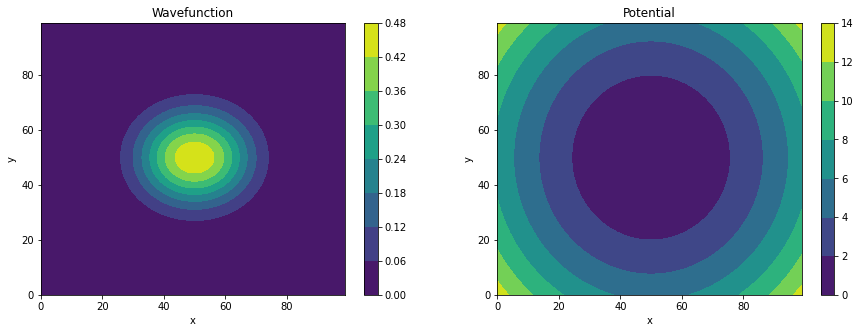

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx = 1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(V[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

# Ground state potentials

Now that we have generated the code to approximate the eigenstates of a random potential, we are going to generate random potentials of the form:

$$
V(x,y) = \alpha_{00} + \alpha_{10} x + \alpha_{01}y + \alpha_{11}xy + \alpha_{20} x^2 + \alpha_{02}y^2 + \alpha_{21}x^2y + \alpha_{12}xy^2 + \alpha_{03}y^3 + \alpha_{30}x^3 + \alpha_{04}y^4 + \alpha_{13}xy^3 + \alpha_{22}x^2y^2 + \alpha_{31}x^3y + \alpha_{40}x^4
$$

To ensure that the eigenstates have discrete energies (and thus are physical states), we will impose some properties on the coefficients, so that the even terms ($x^2$ and $x^4$) dominate over the odd term ($x^3$). Also, we allow the potential to be negative and non-centered by including negative values of $\alpha_0$ and $\alpha_1$. Finally, we will use small values of the coefficients so that the potential does not achieve very high values, which can lead to numerical unstability.


In [ ]:
#@title Code to generate data

#@markdown Double click to see the code


#@markdown ---
#@markdown ### Enter parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 200#@param {type:"integer"}
n_samples = 100#@param {type:"integer"}
#@markdown ---

alpha_min = np.array([[-150,-10,0.2, -0.05, 0],
                      [-10,-0.1,-0.1, -0.05, 0],
                      [0.2,-0.1,0, 0, 0],
                      [-0.05, -0.05,0,0,0],
                      [0,0,0,0,0]])/50

alpha_max = np.array([[50,5,1.0, 0.05, 0.2],
                      [5,0.1,0.1, 0.05, 0],
                      [1.0,0.1,0.2,0,0],
                      [0.05, 0.05, 0,0,0],
                      [0.2,0,0,0,0]])/50

k = alpha_min.shape[0]

r_alpha = np.random.random((int(n_samples*0.8), k,k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([[-150,-10,0.2,0,0],
                      [-10,-0.1,0,0,0],
                      [0.2,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

alpha_max2 = np.array([[50,5,1.0,0,0],
                      [5,0.1,0,0,0],
                      [1.0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

r_alpha = np.random.random((int(n_samples*0.2), k,k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))


## Convergence of the method

In order to choose the value of $N$, we will generate the ground-state energies for different vales of $N$ and compute the difference. When the value of the energy stabilizes up to certain precision $\gamma$, we will fix the value of $N$. We will evaluate the performance for $n\_samples$ different samples.

In [ ]:
gamma = 0.001
Ns = np.arange(3,51)
Es = np.zeros(( Ns.shape[0], n_samples))

for i in range(Ns.shape[0]):
  print("\nSample {}\{}".format(i, Ns.shape[0]))
  data_gen = eigen_state_potential2D(alpha_min, alpha_max, Ns[i])
  E, a, _ = data_gen.generate_data(n_samples, alpha)
  Es[i,:] = E

In [ ]:
#@title Example energy as a function of N
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot


fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ns,
    y=Es[:,0],
    mode="lines",
    name = "sample1")
    )

fig.add_trace(go.Scatter(
    x=Ns,
    y=np.repeat(Es[-1,0], Ns.shape[0]),
    mode="lines",
    name = "sample2")
    )


fig.update_layout(
    title="Energies as a function of N",
    xaxis_title="N")

fig.show()

We see that the energy stabilizes fast. Now, for $\gamma =0.001$, let's see which is the $N$ needed on average to ensure convergence.

In [ ]:
#@title Evolution of difference of energy
gamma=0.02
E_dif = np.abs(Es[:-1,:] - Es[1:,:])

E_dif_mean = np.mean(E_dif, axis=1)

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=Ns[1:],
    y=E_dif_mean,
    mode="lines",
    name = "Difference in energy")
    )
fig.add_trace(go.Scatter(
    x=Ns[:-1:],
    y=np.repeat(gamma, (Ns[1:]).shape[0]),
    mode="lines",
    name = "Gamma")
    )

We see that for $N=32$ the difference in the ground energy is below $\gamma$. Thus, we select this value to generate the wavefunctions. 

## Generating the data to train a neural network model

In [ ]:
#@title Code to generate data

#@markdown Double click to see the code \\
#@markdown **Note: This cell may take some hours to run. 
#@markdown You can skip it and load the generated data instead**


#@markdown ---
#@markdown ### Enter parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---


alpha_min = np.array([[-150,-10,0.2, -0.05, 0],
                      [-10,-0.1,-0.1, -0.05, 0],
                      [0.2,-0.1,0, 0, 0],
                      [-0.05, -0.05,0,0,0],
                      [0,0,0,0,0]])/50

alpha_max = np.array([[50,5,1.0, 0.05, 0.2],
                      [5,0.1,0.1, 0.05, 0],
                      [1.0,0.1,0.2,0,0],
                      [0.05, 0.05, 0,0,0],
                      [0.2,0,0,0,0]])/50

k = alpha_min.shape[0]
r_alpha = np.random.random((int(n_samples*0.8), k,k)) # Values between 0 and 1
alpha1 = r_alpha*(alpha_max - alpha_min)+ alpha_min # random alpha

alpha_min2 = np.array([[-0.5,-0.1,0.2,0,0],
                      [-0.1,-0.05,0,0,0],
                      [0.2,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])

alpha_max2 = np.array([[0.5,0.5,1.0,0,0],
                      [0.5,0.1,0,0,0],
                      [1.0,0,0,0,0],
                      [0,0,0,0,0],
                      [0,0,0,0,0]])


r_alpha = np.random.random((int(n_samples*0.2), k,k)) # Values between 0 and 1
alpha2 = r_alpha*(alpha_max2 - alpha_min2)+ alpha_min2 # random alpha
alpha = np.concatenate((alpha1, alpha2))


data_gen = eigen_state_potential2D(alpha_min, alpha_max, N)
# Generate the energies, wavefunctions and potentials
E, a, alpha = data_gen.generate_data(n_samples, alpha)
waves, x,phis = data_gen.final_wavefunction( xmin, xmax, n_points, a)
V, _ = data_gen.evaluate_potential( xmin, xmax, n_points, alpha)
idx=-1


In [ ]:
#@title Code to save the generated data
#@markdown Double click to see the code \\
#@markdown **Note: Only run this cell if you have generated new data and want 
#@markdown  to overwrite the previously saved one. Notice that this could alter 
#@markdown the results of the notebook.**
# Save data
with open("./Random_potentials/2D/n0/data/power4/V_all.npy", 'wb') as f:
  np.save(f, V)
with open("./Random_potentials/2D/n0/data/power4/waves_all.npy", 'wb') as f:
  np.save(f, waves)
with open("./Random_potentials/2D/n0/data/power4/x_all.npy", 'wb') as f:
  np.save(f, x)
with open("./Random_potentials/2D/n0/data/power4/alpha_all.npy", 'wb') as f:
  np.save(f, alpha)
with open("./Random_potentials/2D/n0/data/power4/a_all.npy", 'wb') as f:
  np.save(f, a)

In [6]:
#@title Code to load the data { vertical-output: true }
#@markdown Double click to see the code \\
#@markdown  **Note: Run this cell to load the saved data**
# Load data
with open("./Random_potentials/2D/n0/data/power4/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Random_potentials/2D/n0/data/power4/waves_all.npy", 'rb') as f:
  waves = np.load(f)
with open("./Random_potentials/2D/n0/data/power4/x_all.npy", 'rb') as f:
  x = np.load(f)
with open("./Random_potentials/2D/n0/data/power4/alpha_all.npy", 'rb') as f:
  alpha = np.load(f)
with open("./Random_potentials/2D/n0/data/power4/a_all.npy", 'rb') as f:
  a = np.load(f)

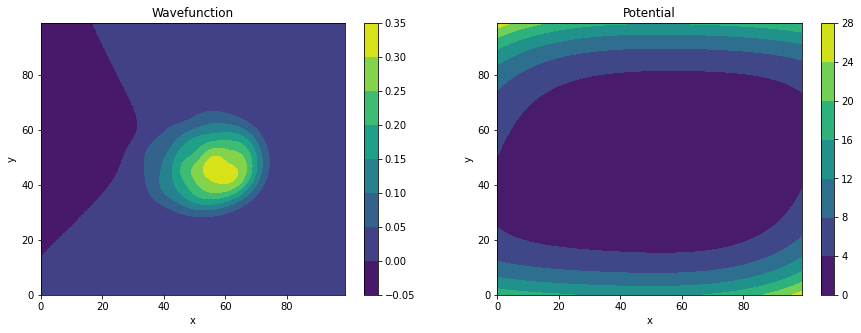

In [7]:
#@title Example of potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx =1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(V[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

## Training a neural network



In [8]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [9]:
#@title Class to train the network
#@markdown Double click to see the code
class Training():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))#tf.keras.losses.MeanSquaredError(y_true_reshaped, y_pred)

  def evaluate_loss(self, y_true, y_pred):
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    f = tf.keras.losses.MeanSquaredError()
    l = []
    for i in range(y_true.shape[0]):
      l1 = f(y_true_reshaped[i,:], y_pred[i,:])
      l2 = f(y_true_reshaped[i,:], - y_pred[i,:])
      l.append(np.min([l1,l2]))
    return np.mean(l)

  def loss_val(self, x_val, y_val):
      '''
      Computes the validation loss 
      Args:
        x_val(tensor): batch of validation sample
        y_val (tensor): labels for validation
      Returns:
         val_loss(tensor): validation loss
      '''
      pred_val = self.net(x_val, False)
      val_loss = self.loss( y_val, pred_val)
      return val_loss

  def early_stop(self, epoch, val_loss, stop):
      '''
      Assesses if we have to stop training
      Args:
         epoch (int): current epoch
         val_loss (tensor): current validation loss
         stop (bool): early stop parameter
      Returns:
         stop(bool): True if the models stops training, false if it continues training
      '''
      #Store best validation loss
      if epoch == 0:
          self.best_loss = val_loss
      else:
          if val_loss < self.best_loss:
              self.stopping_step = 0
              self.best_loss = val_loss
          else:
              #If the validation loss does not decrease, we increase the number of stopping steps
              self.stopping_step += 1
      #If such number reaches the maximum, we stop training
      if self.stopping_step == self.early_stopping:
          stop = True
          print('Early stopping was triggered ')
      return stop

    # Optimization process. 
  @tf.function()
  def run_optimization(self,x, y):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
        y (tensor): Labels for training data
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          loss = self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  #@tf.function
  def fit(self, X_train,y_train, X_test,y_test, save=True):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data
      y_train (numpy array): Labels training data
      X_test (numpy array): Processed test data
      y_test (numpy array): Labels test data
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
    y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
    X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
    y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)
    

    test_data = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    test_data = test_data.shuffle(buffer_size=1024).batch(self.batch_size) 

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters and stop == False:
        for step, (batch_x_train, batch_y_train) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train)
            loss_batch.append(loss.numpy())

        for (test_x, test_y) in test_data:
            #Compute validation loss
            val_loss = self.loss_val(test_x, test_y)
            val_loss_batch.append(val_loss.numpy())
        
        stop = self.early_stop(epoch, val_loss, stop)
        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Validation loss: ", val_loss.numpy(), "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [10]:
#@title Split training and test data
from sklearn.model_selection import train_test_split

# Split train and test 
idx_train, idx_test, wave_train, wave_test = train_test_split(np.arange(V.shape[0]), waves, test_size=0.33, random_state=123)
V_train = V[idx_train,:]
V_test = V[idx_test,:]

alpha_train = alpha[idx_train]
alpha_test = alpha[idx_test]


In [11]:
#@title Parameters to tran the neural network { output-height: 10 }
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter the data parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the training parameters:
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath = "./Random_potentials/2D/n0/coupled/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.3#@param {type:"number"}
#@markdown ---




In [37]:
idx = np.random.choice(20000, 5000)

V2 = V[idx,:,:]
V2 = np.concatenate((V2, potential), axis=0)

waves2 = waves[idx,:,:]
waves2 = np.concatenate((waves2, phi_0), axis=0)

In [40]:
waves2.shape

(6000, 100, 100)

In [12]:
#@title Run this cell to load model
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2,
                          n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, 
                 batch_size, display_step, filepath=filepath,
                 early_stopping=100, restore=True)


Restored from ./Random_potentials/2D/n0/coupled/tf_ckpts/ckpt-1


In [12]:
#@title Run this cell to train the network
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, 
                          n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters,
                 batch_size, display_step, filepath=filepath,
                 early_stopping=100, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  2.465767e-06 Loss:  2.1712472e-06
Epoch:  20 Validation loss:  1.5032363e-06 Loss:  1.6690348e-06
Epoch:  30 Validation loss:  1.4894442e-06 Loss:  1.3491865e-06
Epoch:  40 Validation loss:  1.1839755e-06 Loss:  1.0210193e-06
Epoch:  50 Validation loss:  1.0865033e-06 Loss:  8.2806173e-07
Epoch:  60 Validation loss:  1.2611702e-06 Loss:  5.927573e-07
Epoch:  70 Validation loss:  3.2759291e-07 Loss:  5.8041496e-07
Epoch:  80 Validation loss:  4.8936e-07 Loss:  5.679856e-07
Epoch:  90 Validation loss:  5.198012e-07 Loss:  4.5952532e-07
Epoch:  100 Validation loss:  3.907971e-07 Loss:  5.4915773e-07
Epoch:  110 Validation loss:  8.307619e-07 Loss:  3.1634744e-07
Epoch:  120 Validation loss:  3.569317e-07 Loss:  3.7883873e-07
Epoch:  130 Validation loss:  1.5398498e-07 Loss:  3.3551572e-07
Epoch:  140 Validation loss:  1.1598509e-07 Loss:  2.8657362e-07
Epoch:  150 Validation loss:  3.007656e-07 Loss:  2.53586e-07
Epoch:  160 Validation loss:  3.966612e-07 Loss

In [26]:
#@title Make predictions
idx = np.arange(500)
pred = conv_model(V_test[idx,:,:])
print("Test MAE: %f" % train.loss(pred, wave_test[idx,:,:]))
pred = pred.numpy().reshape(-1,n_points,n_points)
idx = -1

Test MAE: 0.000000


In [34]:
np.mean((wave_test[idx] - pred)**2)

2.1825798650792749e-07

## Plot the results

We plot the prediction and the real values of the wave function.

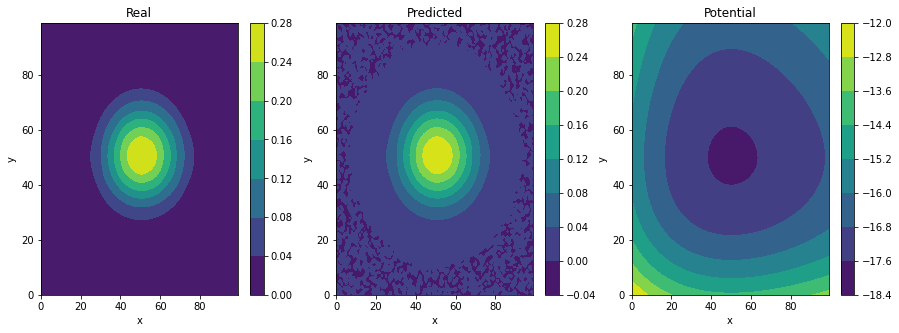

In [27]:
#@title
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))

cs1 = ax1.contourf(wave_test[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(V_test[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [15]:
#@title Code to calculate the empirical energy
#@markdown Double click to show code
def empirical_energy(phi, potential, xmin=-8, xmax = 8,n_points=100, hbar=1, m=1):
    h = (xmax - xmin)/n_points
    phi = np.asarray(phi)
    if phi.shape!= potential.shape:
      phi = np.reshape(phi, potential.shape)
    # We first calculate the second derivative of phi
    # derivative x
    phir = phi.copy()
    phir[:,0] = 0
    phir[:,1:] = phi[:,:-1]
    phil = phi.copy()
    phil[:,-1] = 0
    phil[:,:-1] = phi[:,1:]
    deriv_x = (phir - 2*phi + phil)/(h*h)

    # derivative y
    phir = phi.copy()
    phir[0,:] = 0
    phir[1:,:] = phi[:-1,:]
    phil = phi.copy()
    phil[-1,:] = 0
    phil[:-1,:] = phi[1:,:]
    deriv_y = (phir - 2*phi + phil)/(h*h)

    # Now we calculate the mean energy
    energy = np.sum((-hbar*hbar/(2*m)*phi*(deriv_x + deriv_y) + potential*(phi*phi))*h*h)
    return energy

In [17]:
#@title Code to calculate the empirical energy
#@markdown Double click to show code

def empirical_energy1D( phi, potential, xmin=-8, xmax = 8,
                       n_points=200, hbar=1, m=1):
    # Normalize phi just in case
    h = (xmax - xmin)/n_points

    def energy(phi,potential,h):
      C = 1./np.sqrt(np.sum(phi*phi*h))
      phi = C*phi
      # We first calculate the second derivative of phi
      phir = np.concatenate(( phi[1:], np.zeros(1)), axis=0) # We add 0 at the extrema. It makes sense because phi(x)->0 at x->+-inf
      phil = np.concatenate(( np.zeros(1), phi[:-1]), axis=0)
      
      deriv = (phir - 2*phi + phil)/(h*h)
      return np.sum((-hbar*hbar/(2*m)*phi*deriv + potential*(phi*phi))*h)

    E = np.array([energy(phi[i,:], potential[i,:], h) for i in range(phi.shape[0])])   
    return E

def empirical_energy(phi, potential, xmin=-10, xmax = 10,
                       ymin=-10, ymax = 10,
                       n_points=100, hbar=1, m=1):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = np.asarray(phi)
    if phi.shape!= potential.shape:
      phi = np.reshape(phi, potential.shape)

    # We first calculate the second derivative of phi
    # derivative x
    phir = phi.copy()
    phir[:,:,0] = 0
    phir[:,:,1:] = phi[:,:,:-1]
    phil = phi.copy()
    phil[:,:,-1] = 0
    phil[:,:,:-1] = phi[:,:,1:]
    deriv_x = (phir - 2*phi + phil)/(h1*h2)

    # derivative y
    phir = phi.copy()
    phir[:,0,:] = 0
    phir[:,1:,:] = phi[:,:-1,:]
    phil = phi.copy()
    phil[:,-1,:] = 0
    phil[:,:-1,:] = phi[:,1:,:]
    deriv_y = (phir - 2*phi + phil)/(h1*h2)

    # Now we calculate the mean energy
    energy = np.sum((-hbar*hbar/(2*m)*phi*(deriv_x + deriv_y) + potential*(phi*phi))*h1*h2, axis=(1,2))
    return energy

In [39]:
idx = np.arange(500)
E = empirical_energy(wave_test[idx], V_test[idx],xmin=-10, xmax = 10, n_points=100)
E_emp = empirical_energy(pred[idx], V_test[idx],xmin=-10, xmax = 10, n_points= 100)

print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  5.7081372565894766e-05


In [35]:
#@title Predicted and Real mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Test with Harmonic Oscillator

In [40]:
#@title Class to generate data of the Harmonic Oscillator
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_hermite
import math 

class Harmonic_Oscillator2D:

  def __init__(self, omega_min = 0.001, omega_max = 1, x0_min = -0.5, x0_max = 0.5,
               hbar = 1, m = 1, xmin = -8, xmax = 8, n_points = 200):
    self.omega_min = omega_min # omega ~ U(omega_min, omega_max)
    self.omega_max = omega_max
    self.x0_min = x0_min
    self.x0_max = x0_max
    self.hbar = hbar
    self.m = m
    self.n_points = n_points # Number of points of the grid 
    self.omega_x=np.array([None])
    self.omega_y = np.array([None])
    self.x0 = np.array([None])
    self.y0 = np.array([None])
    self.xmin = xmin
    self.xmax = xmax


  def generate_omega(self, N):
    self.omega_x = np.random.uniform(self.omega_min, self.omega_max, N)
    self.omega_y = np.random.uniform(self.omega_min, self.omega_max, N)
    self.x0 = np.random.uniform(self.x0_min, self.x0_max, N)
    self.y0 = np.random.uniform(self.x0_min, self.x0_max, N)
    
  def order_energy(self,n_state, omegax, omegay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """

    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    nxs = np.zeros((n_state+1)**2)
    nys = np.zeros((n_state+1)**2)
    Es = np.zeros((n_state+1)**2)
    i=0
    for nx in range(n_state+1):
      for ny in range(n_state+1): 
          nxs[i] = nx
          nys[i] = ny
          Es[i] = self.hbar*(omegax*(nx+1/2) + omegay*(ny + 1/2))
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def HO_wavefunction(self,n, x0, omega, n_points):
      '''
      Returns the nth eigenfunction of the harmonic oscillator in the points x
      Args:
        n (int): Energy level
        x0 (float):  Value of x0
        omega (float): Value of omega
        n_points (int): Number of points between xmin and xmax
      Returns:
        phi_n (np.array): size n_points. Phi_n(x)
      '''

      x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points)
      sigma_inv = np.sqrt(self.m*omega/self.hbar)
      all_x = (x - x0)*sigma_inv # It is a matrix of dim (num_x_points), 
      herm = eval_hermite(n, all_x) # H_n(x/sigma)
      exp = np.exp(- all_x**2/2) # Exponential term
      phi_n = exp*herm

      potential = (x-x0)**2 * 1/2*self.m*omega**2

      return phi_n, potential,x

  def generate_data(self, N=None, n = 0, new_omega=True):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_omega or (self.omega_x==None).any() or (self.omega_y==None).any() or (self.y0==None).any() or (self.x0==None).any():
      self.generate_omega(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,n_points))
    potential_y = np.zeros((N,n_points))
    phi_x = np.zeros((N,n_points))
    phi_y = np.zeros((N,n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)

    for sample in range(N):
      nx, ny = self.order_energy(n, self.omega_x[sample], self.omega_y[sample])
      nxs[sample] = nx
      nys[sample] = ny
      p_x, pot_x, x = self.HO_wavefunction(nx, self.x0[sample], self.omega_x[sample], self.n_points)
      p_y, pot_y, y = self.HO_wavefunction(ny, self.y0[sample], self.omega_y[sample], self.n_points)
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y

    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h = (self.xmax - self.xmin)/self.n_points
    for i in range(N):
      phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
      phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
      phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
      C = 1./np.sqrt(np.sum(phi_i*phi_i*h*h)) # Normalization constant
      phi[i,:,:] = C*phi_i
      # Potential
      pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
      pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
      potential[i,:,:] = pot_x + pot_y

    return phi, x, self.omega_x, self.omega_y, self.x0, self.y0, potential, nxs, nys

  def get_energy(self, n, omega_x=np.array([None]), omega_y=np.array([None])):
    if (omega_x==None).any() or (omega_y==None).any():
      omega_x = self.omega_x
      omega_y = self.omega_y
    nx,ny = get_nx_ny(n)
    E = self.hbar*(omega_x*(nx+1/2) + omega_y*(ny + 1/2))
    return E.flatten()



In [42]:
#@title Generate H.O data { form-width: "30%" }
ho = Harmonic_Oscillator2D(n_points =n_points, xmin=-8, xmax=8, omega_min=0.3, 
                           omega_max = 1.0, x0_min = -0.05, x0_max = 0.05)

phi_0, x, omega_x, omega_y, x0, y0, potential, nxs, nys = ho.generate_data(500,0)

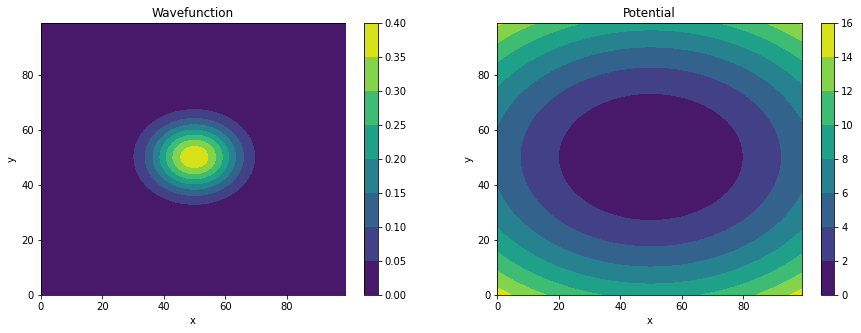

In [43]:
#@title Example of potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx = 0
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

In [45]:
#@title Predict wavefunctions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, phi_0))
pred = pred.numpy().reshape(-1,n_points, n_points)

Test MAE: 0.000012


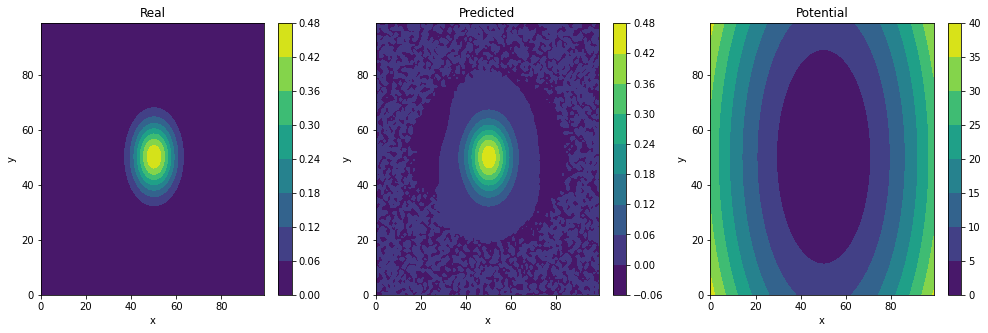

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [46]:
E = empirical_energy(phi_0, potential,xmin=-10, xmax = 10, n_points=100)
E_emp = empirical_energy(pred, potential,xmin=-10, xmax = 10, n_points= 100)
print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  0.0003911549604573529


In [47]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Harmonic oscillator energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Test with Morse potential

In [48]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)

    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    pot = z**(lamb -n -1/2) # Potential term

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    phi_n = pot*exp*laguerre
    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
  
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys


  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [78]:
#@title Generate Morse Data { form-width: "30%" }
n_points=100
morse = Morse2D(n_points = n_points,  x_min = -8, x_max=8,y_min = -8, y_max=8, xe_min =-0.05,
              xe_max = 0.05, a_min = 0.09, a_max = 0.09, De_max = 10, De_min =7)

phi_0, x,y, potential, a_x, a_y, De_x, De_y, xe, ye, nxs, nys = morse.generate_data(500,0, True) 
idx=0

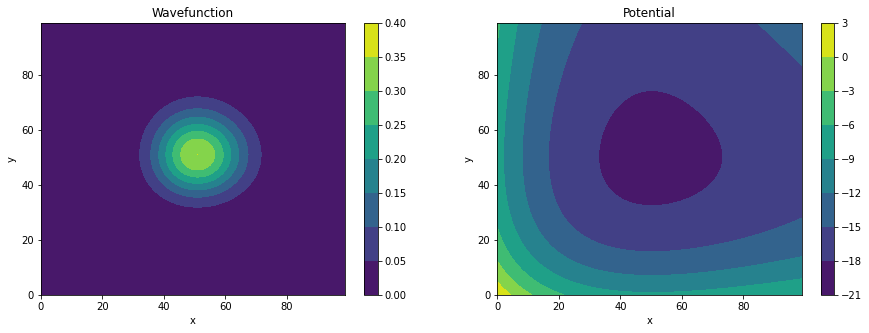

In [79]:
#@title Example of potential and wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

In [80]:
#@title Predict wavefunctions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, phi_0))
pred = pred.numpy().reshape(-1,n_points, n_points)

Test MAE: 0.000006


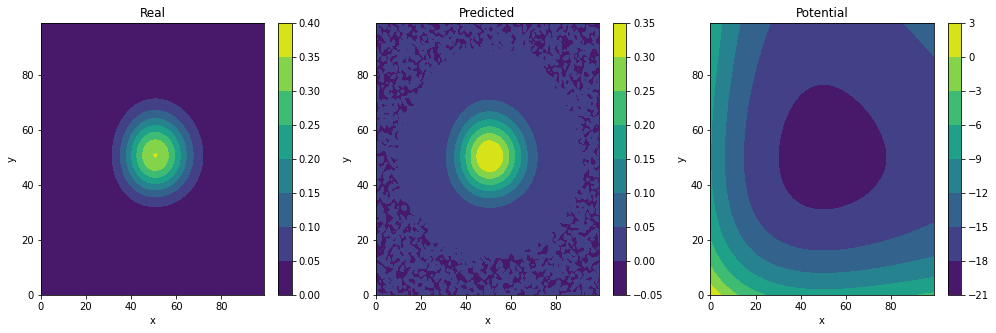

In [81]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))

cs1 = ax1.contourf(phi_0[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(pred[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [84]:
E = empirical_energy(phi_0, potential,xmin=-10, xmax = 10, n_points=100)
E_emp = empirical_energy(pred, potential,xmin=-10, xmax = 10, n_points= 100)
print('MSE(E) = ', np.mean((E-E_emp)**2))

MSE(E) =  0.00010798170226293741


In [83]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Coupled Morse potentials

Now we are going to test the model with two coupled morse potentials. The Hamiltonian in this case is:


$$
H(x_1, x_2, p_1, p_2) = \frac{1}{2}(G_{11}p_1^2 + G_{22}p_2^2) + G_{12}p_1p_2 + U_M(x_1) + U_M(x_2)
$$

Where 
$$
G_{11} = G_{22} = \frac{m_H + m_O}{m_Hm_O}, \quad G_{12} = \frac{cos(\alpha)}{m_O}
$$

And $U_M(x)$ is a one-dimensional morse potential. We can rewrite this potential in generalized coordinates so that the coupling appears in the spatial coordinates instead than in the momentum coordinates. In order to do so, we apply a canonical transformation to the Hamiltonian $H(x_1,x_2,p_1,p_2)$ obtaining the Hamiltonian $H'(x_1', x'_2, p_1', p_2')$. We use a generating function of the form $F_2(x_1, x_2, p_1', p_2')$. In this case we know that:

$$
\left\{
\begin{array}{ll}
p_i =& \frac{\partial F_2}{\partial x_i}, \ i \in \{1,2\}\\
x_i' =& \frac{\partial F_2}{\partial p_i'}, \ i \in \{1,2\}\\
H' =& H + \frac{\partial F_2}{\partial t}
\end{array} 
\right.
$$

Now we propose a generating function $F_2(x_1,x_2, p_1', p_2')$ of the form:

$$
F_2(x_1,x_2, p_1', p_2') = f_1(x_1,x_2)p_1' + f_2(x_1,x_2)p_2'
$$

Then, the generalized coordinates must fulfill the following equations

$$
\left\{
\begin{array}{ll}
p_1 = \frac{\partial F_2}{\partial x_1} = \frac{\partial f_1}{\partial x_1}p_1' +\frac{\partial f_2}{\partial x_1}p_2' \\
p_2 = \frac{\partial F_2}{\partial x_2} = \frac{\partial f_1}{\partial x_2}p_1' +\frac{\partial f_2}{\partial x_2}p_2'\\
x_1' = \frac{\partial F_2}{\partial p_1'} = f_1(x_1,x_2)\\
x_2' = \frac{\partial F_2}{\partial p_2'} = f_2(x_1,x_2)
\end{array} 
\right.  
$$

Notice that the kinetic energy can be written in terms of matrices as:

$$
T(p_1,p_2) = \begin{pmatrix}
p1 & p2\\
\end{pmatrix} \frac{1}{2}
\begin{pmatrix}
G_{11} & G_{12}\\
G_{12} & G_{11}
\end{pmatrix}
\begin{pmatrix}
p1\\
p2\\
\end{pmatrix} := \begin{pmatrix}
p1 & p2\\
\end{pmatrix} 
M
\begin{pmatrix}
p1\\
p2\\
\end{pmatrix}
$$

Thus, we can diagonalize the previuos matrix $M$ so that:
$$
M = S\cdot D \cdot S^T, \quad
S = \frac{1}{\sqrt{2}}
\begin{pmatrix}
-1 & 1\\
1 & 1\\
\end{pmatrix}, \quad
D = 1/2 \begin{pmatrix}
G_{11} - G_{12} & 0\\
0 & G_{11} + G_{12}
\end{pmatrix}
$$

Therefore, if we define the new coordinates $\vec{p'} = S^T \vec{p}$, the new kinetic energy will only contain diagonal terms:

$$
T'(p_1', p_2') = \frac{1}{2} ( (G_{11}-G_{12})p_1'^2 + (G_{11}+G_{12})p_2'^2) 
$$

Now we use the generalized coordinates equations to find the conjugate coordinates $(x_1', x_2')$:

$$
\frac{\partial f_1}{\partial x_1} = -\frac{1}{\sqrt{2}}, \ \frac{\partial f_1}{\partial x_2} = \frac{1}{\sqrt{2}}, \ \frac{\partial f_2}{\partial x_1} = \frac{1}{\sqrt{2}}, \ \frac{\partial f_2}{\partial x_2} = \frac{1}{\sqrt{2}}
$$

And therefore
$$
x_1' = f_1(x_1,x_2) = \frac{1}{\sqrt{2}}(-x_1 + x_2), \quad x_2' = f_2(x_1,x_2) = \frac{1}{\sqrt{2}}(x_1 + x_2)
$$
And the inverse transformation is
$$
x_1 = \frac{1}{\sqrt{2}}(-x_1' + x_2'), \quad x_2  = \frac{1}{\sqrt{2}}(x_1' + x_2')
$$

And we obtain the Hamiltonian

$$
H'(x_1', x_2', p_1', p_2') = \frac{1}{2}((G_{11}-G_{12})p_1'^2 + (G_{11}+G_{12})p_2'^2) + U_M(\frac{1}{\sqrt{2}}(x_2' - x_1')) + U_M(\frac{1}{\sqrt{2}}(x_1' + x_2'))
$$
Finally, we scale the coordinates so that both particles have the same mass. We define

$$
X_1 = \frac{1}{\sqrt{G_{11} - G_{12}}}x_1', \quad X_2 = \frac{1}{\sqrt{G_{11} + G_{12}}}x_2', \quad P_1 = \dot{X_1}, \quad P_2 = \dot{X_2}
$$
And we obtain the decoupled Hamiltonian
$$
K(X_1, X_2, P_1, P_2) = \frac{1}{2}(P_1^2 + P_2^2) + U_M(\frac{1}{\sqrt{2}}\Big(\sqrt{G_{11} + G_{12}}X_2- \sqrt{G_{11} - G_{12}}X_1\Big)) + U_M(\frac{1}{\sqrt{2}}\Big(\sqrt{G_{11} + G_{12}}X_2+ \sqrt{G_{11} - G_{12}}X_1\Big))
$$

This equivalent Hamiltonian has no coupling between the momentum $P_1$ and $P_2$, which has been moved to the coordinates $X_1$ and $X_2$. In order to further illustrate this aspect, we can compute the Taylor expansion of the Hamiltonian. We obtain

$$
K(X_1, X_2, P_1, P_2) = \frac{1}{2}(P_1^2 + P_2^2) -2D + Da^2(G_{11}-G_{12})X_1^2 + Da^2(G_{11}+G_{12})X_2^2 - \frac{3}{\sqrt{2}}Da^3(G_{11}-G_{12})\sqrt{G_{11} + G_{12}}X_2X_1^2 - \frac{1}{\sqrt{2}}Da^3 (G_{11}+G_{12})^{3/2} X_2^3 + O(4)
$$

Where $D$ and $a$ are the bond dissociation energy and the morse parameter respectively. We observe that the expansion contains a term $X_2X_1^2$, which shows that these two coordinates are coupled.


In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

  def get_min_max(self,data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    side = np.abs(np.where(maxima)[0][0] - np.where(minima)[0][0])<tol

    if np.where(maxima)[0][0] > np.where(minima)[0][0]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
      return num_min, num_max, -data, side
    return num_max, num_min, data, side

  def normalize_wave(self, data):
    h = (self.xmax - self.xmin)/self.n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

  def find_true_sate(self, waves, guesses=[6,7,8], true_min=3, true_max=3):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
      for guess in guesses:
        data = waves_tot[guess, i,:,:]
        num_max, num_min, data, side = self.get_min_max(data)
        if num_max==true_max and num_min==true_min: #and  side:
          waves_sol[i,:,:] = self.normalize_wave(data)
          break
    print("Error, no state found")
    return waves_sol

In [ ]:
#@title Generate Coupled Morse data { form-width: "30%" }
n_samples = 50
morse = Coupled_Morse_potential(n_points = n_points,  x_min = -8, x_max=8, 
                                y_min = -8, y_max = 8,xe_min =-0.05, 
                                xe_max = 0.05, a_min = 0.09, a_max = 0.1, 
                                De_max = 10, De_min =7)

x, y, potential,waves, alpha, a, De, xe = morse.generate_data(n_samples) 

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 0/50

Since we do not know an exact solution of the wavefunctions, we approximate them using the H.O basis.

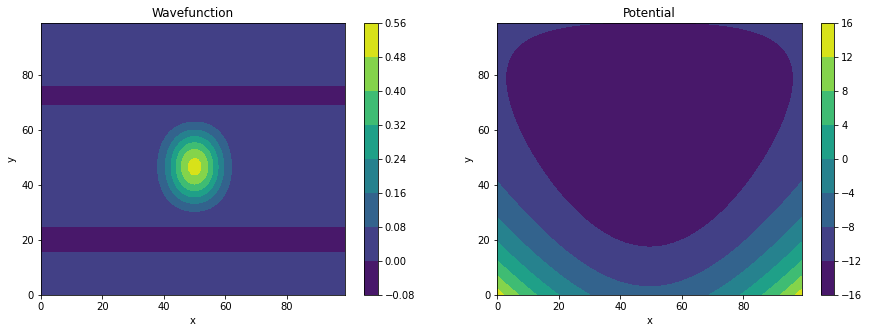

In [ ]:
#@title Example Coupled morse potentials
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Wavefunction")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
cs2 = ax2.contourf(potential[idx,:,:])
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
plt.show()

In [ ]:
#@title Make predictions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, waves))

Test MAE: 0.000000


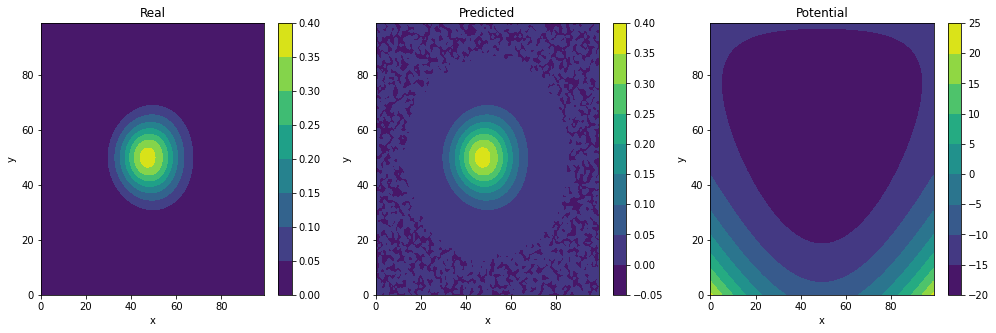

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(17,5))
pred_reshape = pred.numpy().reshape(-1, n_points, n_points)

cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred_reshape[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = np.array([empirical_energy(waves[i,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])
E_emp = np.array([empirical_energy(pred[i,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])

In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

# Excited state for Morse potentials

In this section we are going to generate data following a Hamiltonian with two decoupled morse potentials for a excited state with energy level $(n_x,n_y)$. Then we test the model with the coupled morse potential.

## Generate data

In [ ]:
#@title Code to generate data to fit a coupled morse potential
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False, n_state=7) 

    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+1.5, y_max=self.ymax+5)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+1.5, y_max=self.ymax+5, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 10000
fit_morse = fit_coupled_morse()
V1,waves1,x1,y1,pot1 = fit_morse.fit(n_samples)
V2,waves2,x2,y2,pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n12/data/V_prova.npy",
                   waves,"./Coupled_morse/n12/data/waves_prova.npy",
                   x,"./Coupled_morse/n12/data/x_prova.npy" )

idx=-1

 i=3

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=9

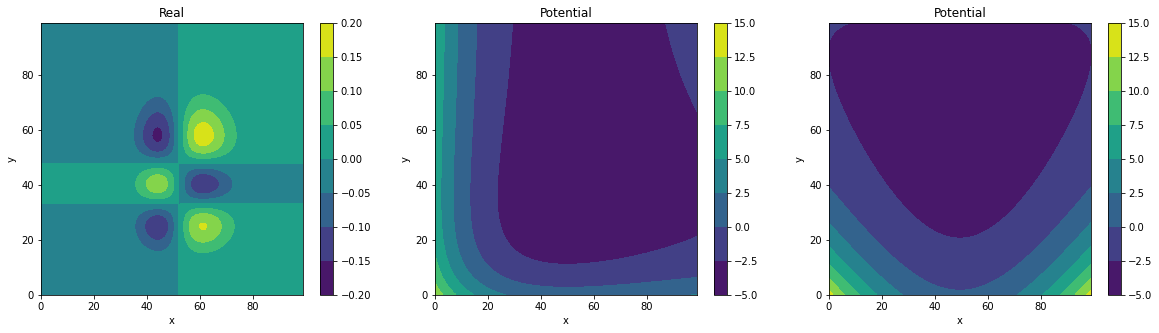

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(20,5))

cs3 = ax3.contourf(pot2[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cs1 = ax1.contourf(waves2[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")


cs2 = ax2.contourf(V1[idx,:,:], levels = cs3.levels)
ax2.set_title("Potential")
ax2.set_xlabel("x")
ax2.set_ylabel("y")


cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
cbar4 = fig.colorbar(cs4, ax=ax4)
plt.show()

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n12/data/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n12/data/waves_all.npy", 'rb') as f:
  waves = np.load(f)
with open("./Coupled_morse/n12/data/x_all.npy", 'rb') as f:
  x = np.load(f)


## Train model

In [ ]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [ ]:
#@title Parameters to tran the neural network { output-height: 10 }
#@markdown You can also include Markdown in forms.

#@markdown ---
#@markdown ### Enter the data parameters:
xmin = -8#@param {type:"number"}
xmax = 8#@param {type:"number"}
N=32#@param {type:"slider", min:20, max:50, step:1}
n_state=0#@param {type:"slider", min:0, max:10, step:1}
n_points = 100#@param {type:"integer"}
n_samples=10000#@param {type:"integer"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the training parameters:
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./Random_potentials/2D/n12/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.3#@param {type:"number"}
#@markdown ---



In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=100, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Restored from ./Random_potentials/2D/n12/tf_ckpts/ckpt-1
Epoch:  10 Validation loss:  3.085924e-08 Loss:  1.6721056e-07
Epoch:  20 Validation loss:  1.8833481e-06 Loss:  1.1312806e-06
Epoch:  30 Validation loss:  8.4547344e-07 Loss:  3.85406e-07
Epoch:  40 Validation loss:  1.5524627e-07 Loss:  4.828576e-08
Epoch:  50 Validation loss:  1.3237548e-07 Loss:  1.7894801e-07
Epoch:  60 Validation loss:  2.0268862e-07 Loss:  1.2264394e-07
Epoch:  70 Validation loss:  1.1490174e-06 Loss:  4.0881656e-07
Epoch:  80 Validation loss:  3.0031524e-07 Loss:  4.952246e-07
Epoch:  90 Validation loss:  3.0912943e-07 Loss:  8.92805e-08
Epoch:  100 Validation loss:  2.5778544e-08 Loss:  1.1196213e-07
Epoch:  110 Validation loss:  7.482548e-08 Loss:  2.2099134e-07
Early stopping was triggered 
Saved checkpoint for step ./Random_potentials/2D/n12/tf_ckpts/ckpt-2


## Generate test data

In [ ]:
#@markdown ---
#@markdown ### Enter the network parameters:
n_samples = 500#@param {type:"integer"}
n_state = 15#@param {type:"integer"}
n_points = 100#@param {type:"integer"}
n0=2#@param {type:"integer"}
xmin=-10#@param {type:"number"}
xmax = 10#@param {type:"number"}

#@markdown ---



morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax, xe_min =-0.05,
              xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 150, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves = morse_coupled.find_true_sate(waves_tot)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: FutureWarning:

`rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.



Generating data: 450/500

In [ ]:
#@title Make predictions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, waves))

Test MAE: 0.000001


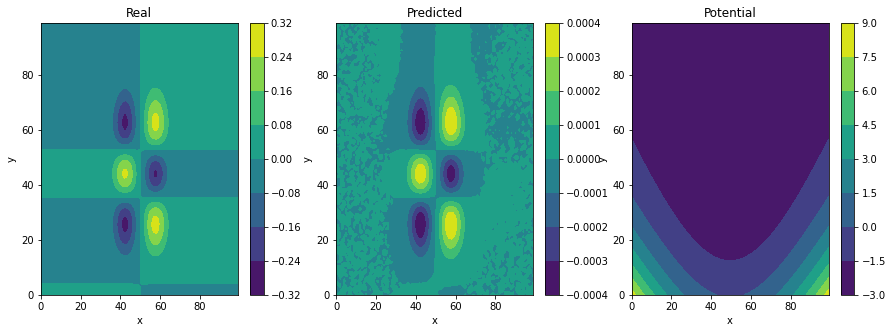

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx =0
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)
h=(xmax-xmin)/n_points
C = 1/np.sum(pred_reshape**2*h*h)
pred_reshape =C*pred_reshape 
cs2 = ax2.contourf(pred_reshape[idx,:,:])
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = np.array([empirical_energy(waves[i,:,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])
E_emp = np.array([empirical_energy(pred[i,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])

In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Try model with other quantum states

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

  def get_min_max(self,data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    side = np.abs(np.where(maxima)[0][0] - np.where(minima)[0][0])<tol

    if np.where(maxima)[0][0] > np.where(minima)[0][0]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
      return num_min, num_max, -data, side
    return num_max, num_min, data, side

  def normalize_wave(self, data):
    h = (self.xmax - self.xmin)/self.n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

  def find_true_sate(self, waves, guesses=[6,7,8], true_min=3, true_max=3):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
      for guess in guesses:
        data = waves[guess, i,:,:]
        num_max, num_min, data, side = self.get_min_max(data)
        if num_max==true_max and num_min==true_min: #and  side:
          waves_sol[i,:,:] = self.normalize_wave(data)
          break
    print("Error, no state found")
    return waves_sol

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real = morse_coupled.find_true_sate(waves_tot,  guesses=[6,7,8], true_min=2, true_max=3)
    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+0.5, y_max=self.ymax+7, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

We look for the parameters of a decoupled morse potential ($D_x$, $a_x$, $D_y$, $a_y$ ) which best approximate the potential of a coupled potential.

In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 10
n_state=50
n0=0

fit_morse = fit_coupled_morse(nx=0, ny=4)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = True)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

#fit_morse.save_all(V, "./Coupled_morse/n05/data/V_prova.npy",
#                   waves,"./Coupled_morse/n05/data/waves_prova.npy",
#                   x,"./Coupled_morse/n05/data/x_prova.npy" )

idx=-1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 9/10Error, no state found
 i=2

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


 i=9

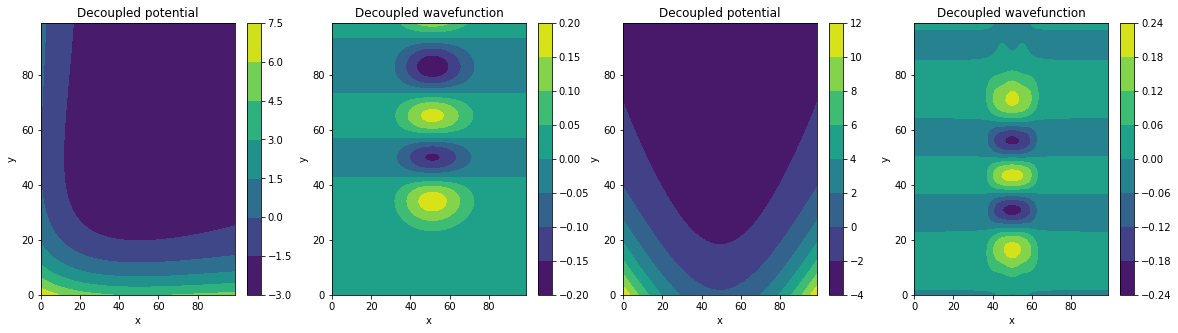

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

cs4 = ax4.contourf(wr[idx,:,:])
ax4.set_title("Decoupled wavefunction")
ax4.set_xlabel("x")
ax4.set_ylabel("y")
fig.colorbar(cs4, ax=ax4)

plt.show()


We see that the wavefunction does not fit our grid. Moreover, the real wavefunction is placed lower in the y direction and it is stretched compared to the decoupled wavefunction. Therefore, we are going to change the values of the x-y grid for the decoupled potential so that the wavefunctions are more similar. We perform a grid search for the variables $x_\min$, $x_\max$, $y_\min$ and $y_\max$.  

In [ ]:
#@title Grid search to find x and y range
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=0, ny=4)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves = morse_coupled.find_true_sate(waves_tot,  guesses=[6,7,8], true_min=2, true_max=3)                                                                   

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess)


  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = 0
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = 0


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9.5,-9,-8.5,-7,-7.5,-6,-6.5],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, new_a=False, nx=0, ny=4) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
        return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 15, 'xmin': -14, 'ymax': 18, 'ymin': -8.5}

In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 5000
n_state=50
n0=0
x_min_fit = -14 
x_max_fit =15
y_min_fit =-8.5
y_max_fit =18
fit_morse = fit_coupled_morse(nx=0, ny=4)
V1,waves1,x1, y2, pot1 = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n05/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n05/data/waves_decoupled.npy",
                   x,"./Coupled_morse/n05/data/x_decoupled.npy" )

idx=-1

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n05/data/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n05/data/waves_all.npy", 'rb') as f:
  waves = np.load(f)
with open("./Coupled_morse/n05/data/x_true.npy", 'rb') as f:
  x = np.load(f)


In [ ]:
#@title Parameters to tran the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./Coupled_morse/n05/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 128#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=64#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 256#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



In [ ]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./Coupled_morse/n05/tf_ckpts/ckpt-1


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=100, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  3.1550405e-06 Loss:  3.657158e-06
Epoch:  20 Validation loss:  4.7197755e-06 Loss:  2.6398957e-06
Epoch:  30 Validation loss:  1.3901322e-06 Loss:  2.1526703e-06
Epoch:  40 Validation loss:  7.6491466e-07 Loss:  1.3467329e-06
Epoch:  50 Validation loss:  7.0114737e-07 Loss:  1.9292713e-06
Epoch:  60 Validation loss:  4.0083856e-07 Loss:  2.684782e-07
Epoch:  70 Validation loss:  6.125614e-05 Loss:  6.5539774e-05
Epoch:  80 Validation loss:  6.131501e-05 Loss:  3.7817298e-07
Epoch:  90 Validation loss:  1.1567571e-06 Loss:  2.4083968e-07
Epoch:  100 Validation loss:  7.070575e-06 Loss:  7.511852e-07
Epoch:  110 Validation loss:  1.1482746e-06 Loss:  8.5721535e-07
Epoch:  120 Validation loss:  5.9924855e-07 Loss:  1.2816736e-06
Epoch:  130 Validation loss:  1.3496214e-06 Loss:  5.794957e-07
Epoch:  140 Validation loss:  1.7468913e-06 Loss:  1.026277e-06
Epoch:  150 Validation loss:  3.447141e-07 Loss:  2.0925683e-07
Epoch:  160 Validation loss:  6.979111e-07 

## Generate test data

In [ ]:
# Generate data
n_samples = 100
n_state = 50
n_points = 100
n0=0
xmin=-10
xmax = 10
G11 = 1.05472
G12 = 0.01559

morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax,
                                        y_min = xmin, y_max=xmax, xe_min =-0.05,
                                        xe_max = 0.05, a_min = 0.09, a_max = 0.1,
                                        De_max = 3, De_min =1)

x, y, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves_real = morse_coupled.find_true_sate(waves_tot,  guesses=[6,7,8], true_min=2, true_max=3)

idx = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 99/100Error, no state found


In [ ]:
#@title Make predictions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, waves_real))
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test MAE: 0.000002


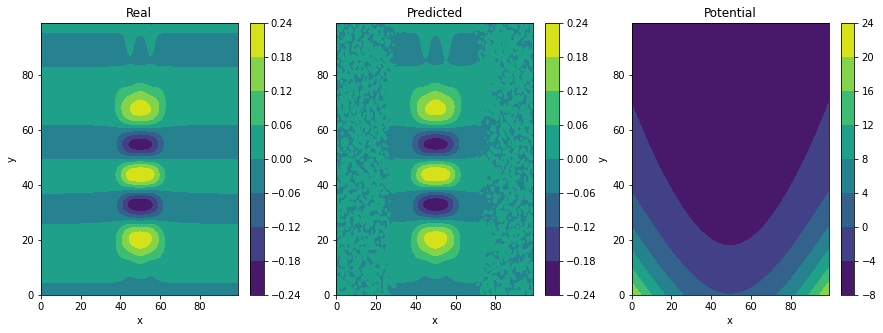

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)

cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = np.array([empirical_energy(waves_real[i,:,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])
E_emp = np.array([empirical_energy(pred[i,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])

In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

# Eigen State $n_x$= 1, $n_y=1$

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

  def get_min_max(self,data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    side = np.abs(np.where(maxima)[0][0] - np.where(minima)[0][0])<tol

    if np.where(maxima)[0][0] > np.where(minima)[0][0]:
      return num_min, num_max, -data, side
    return num_max, num_min, data, side

  def normalize_wave(self, data):
    h = (self.xmax - self.xmin)/self.n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

  def find_true_sate(self, waves, guesses=[6,7,8], true_min=3, true_max=3):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
      for guess in guesses:
        data = waves_tot[guess, i,:,:]
        num_max, num_min, data, side = self.get_min_max(data)
        if num_max==true_max and num_min==true_min and side:
          waves_sol[i,:,:] = self.normalize_wave(data)
          break
    print("Error, no state found")
    return waves_sol

In [ ]:
#@title Get the best x and y range 
#@markdown Double click to see the code
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=0, ny=4)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves = morse_coupled.find_true_sate(waves_tot,  guesses=[4,5], true_min=2, true_max=2)                                                                 

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess)


  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = 0
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = 0


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9.5,-9,-8.5,-7,-7.5,-6,-6.5],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, new_a=False, nx=1, ny=1) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
        return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 10, 'xmin': -17, 'ymax': 18, 'ymin': -10}

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x)) - 2*np.exp(-ax*(x))) + Dy*(np.exp(-2*ay*(y)) - 2*np.exp(-ay*(y)))).ravel()

  def fit(self,n_samples):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False, n_state=6) 
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    #x = np.linspace(self.xmin, self.xmax, self.n_points)
    #y = np.linspace(self.xmin, self.xmax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = 0#popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = 0#popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = -12, x_max=12,
                    y_min =-10, y_max=15)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 

    return V,waves,x,y,potential

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = self.xmin-4, x_max=self.xmax+4,
                    y_min = self.ymin+0.5, y_max=self.ymax+7, xe_min =-0.05,
                    xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 7, De_min =1)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 5000
fit_morse = fit_coupled_morse(nx=1, ny=1)
V1,waves1,x1, y2, pot1 = fit_morse.fit(n_samples)
V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n11/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n11/data/waves_decoupled.npy",
                   x,"./Coupled_morse/n11/data/x_decoupled.npy" )

idx=-1

 i=2

/usr/local/lib/python3.6/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



 i=4999

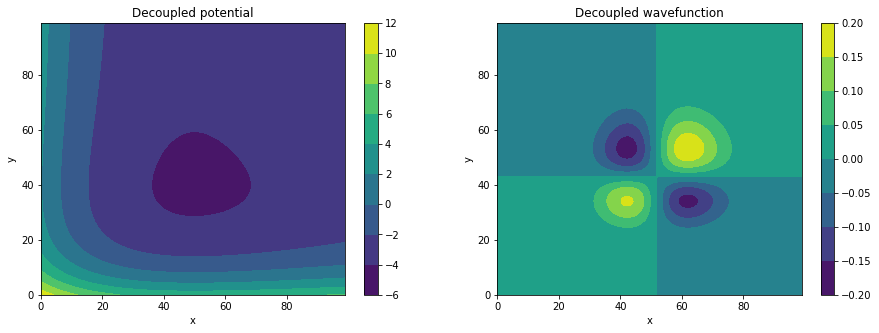

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n11/data/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n11/data/waves_all.npy", 'rb') as f:
  waves = np.load(f)
with open("./Coupled_morse/n11/data/x_true.npy", 'rb') as f:
  x = np.load(f)


In [ ]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters = 1000 #@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 10#@param {type:"integer"}
filepath =  "./Coupled_morse/n11/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 128#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=64#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 256#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



In [ ]:
from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, wave_train, wave_test = train_test_split(V, waves, test_size=0.25, random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./Coupled_morse/n11/tf_ckpts/ckpt-1


In [ ]:
#@title Run to train model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train = Training(conv_model,learning_rate, training_iters, batch_size, display_step,
                 filepath=filepath,early_stopping=50, restore=False)
train.fit(V_train, wave_train, V_test, wave_test)

Epoch:  10 Validation loss:  1.179866e-06 Loss:  1.5079148e-06
Epoch:  20 Validation loss:  7.123326e-07 Loss:  1.5480778e-06
Epoch:  30 Validation loss:  4.8772836e-07 Loss:  3.2584651e-07
Epoch:  40 Validation loss:  2.403845e-07 Loss:  2.2100119e-07
Epoch:  50 Validation loss:  8.866312e-08 Loss:  1.9216085e-07
Epoch:  60 Validation loss:  8.526055e-08 Loss:  7.991695e-08
Epoch:  70 Validation loss:  9.185866e-08 Loss:  9.925963e-08
Epoch:  80 Validation loss:  7.732369e-08 Loss:  1.6909075e-07
Epoch:  90 Validation loss:  8.124215e-08 Loss:  6.814467e-08
Epoch:  100 Validation loss:  1.8220238e-08 Loss:  1.9687224e-08
Epoch:  110 Validation loss:  3.2883072e-08 Loss:  2.6904928e-08
Epoch:  120 Validation loss:  2.0029653e-08 Loss:  2.1236415e-08
Epoch:  130 Validation loss:  2.5214211e-08 Loss:  2.2013383e-08
Epoch:  140 Validation loss:  3.176625e-07 Loss:  1.3984496e-07
Epoch:  150 Validation loss:  1.2337804e-07 Loss:  2.6203704e-08
Epoch:  160 Validation loss:  1.0498603e-08 Lo

## Generate test data

In [ ]:
# Generate data
n_samples = 100
n_state = 50
n_points = 100
n0=0
xmin=-10
xmax = 10
G11 = 1.05472
G12 = 0.01559

morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin, x_max=xmax,
                                        y_min = xmin, y_max=xmax, xe_min =-0.05,
                                        xe_max = 0.05, a_min = 0.09, a_max = 0.1,
                                        De_max = 3, De_min =1)

x, y, potential,waves_tot, alpha, a, De, xe = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

waves_real = morse_coupled.find_true_sate(waves_tot,  guesses=[4,5], true_min=2, true_max=2)

idx = -1

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:82: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


Generating data: 99/100Error, no state found


In [ ]:
#@title Make predictions
pred = conv_model(potential)
print("Test MAE: %f" % train.loss(pred, waves_real))
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test MAE: 0.005100


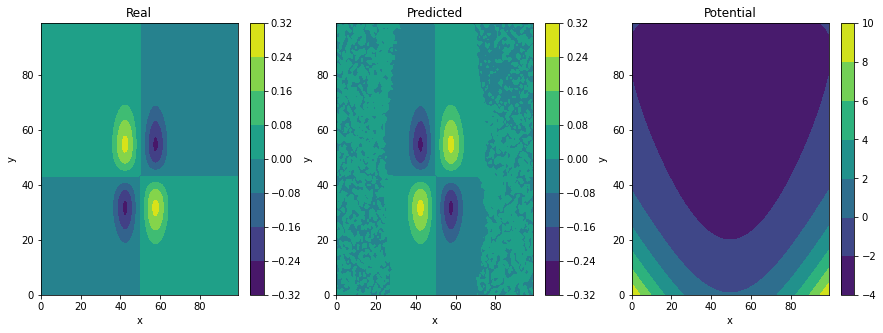

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)

cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(potential[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = np.array([empirical_energy(waves_real[i,:,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])
E_emp = np.array([empirical_energy(pred[i,:], potential[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])

In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

## Anomalous states

In this section we are going to deal with anomalous states, that is, states where the atomic numbers are not well defined.

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe


def get_min_max(data):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)

    if np.where(maxima)[1][1] > np.where(minima)[1][1]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
        return num_min, num_max, -data
    return num_max, num_min, data

def normalize_wave(data):
    h = (xmax - xmin)/n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

def find_true_sate(waves, guesses=[28,29], true_min=11, true_max=10, tol=4):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, n_points, n_points))
    err = np.zeros(len(guesses))
    error = []
    for i in range(n_samples):
        datas = []
        for j in range(len(guesses)):
            data = waves[guesses[j], i,:,:]
            num_max, num_min, true_data  = get_min_max(data)
            datas.append(true_data)
            err[j] = abs(num_max-true_max) + abs(num_min-true_min)
                
        argmin_err = np.argmin(err)
        if err[argmin_err]<=tol:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
        else:
            print("Error, no state found. i: ",  i)
            error.append(i)
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
    return waves_sol, err
  

In [ ]:
#@title Get the best x and y range { form-width: "20%" }
#@markdown Double click to see the code
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.model_selection import GridSearchCV

import scipy.optimize as opt

xmin = -10
xmax = 10
ymin = -10
ymax = 10
n_points = 100
n_samples = 50
fit_morse = fit_coupled_morse(nx=2, ny=6)
n0 = 0
n_state=50

# Generate coupled morse potentials
morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = xmin,
                                        x_max=xmax, y_min=ymin, y_max = ymax, xe_min =0,
                                        xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 250, 
                                                                     new_a = True, get_waves = 'Multi', n0=n0)

waves,_ = find_true_sate(waves_tot, guesses=[28,29], true_min=11, true_max=10, tol=4)                                                         

Dex = np.zeros(n_samples)
Dey = np.zeros(n_samples)
ax = np.zeros(n_samples)
ay = np.zeros(n_samples)
xe = np.zeros(n_samples)
ye = np.zeros(n_samples)
X, Y = np.meshgrid(x, y, copy=False)

for i in range(n_samples):
  initial_guess = (De[i,0], a[i,0], re[i,0], De[i,0], a[i,0], re[i,0])
  bounds=((0.3, 0, -np.inf, 0.3, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.12, 5))
  data = potential[i,:,:].ravel()

  #Fit function
  popt, pcov = opt.curve_fit(fit_morse.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

  Dex[i] = popt[0]
  ax[i] = popt[1]
  xe[i] = popt[2]
  Dey[i] = popt[3]
  ay[i] = popt[4]
  ye[i] = popt[5]


# Now generate data of the decoupled morse using the best fit of the coupled morse
param_grid = {'xmin': [-10,-11,-12,-13,-14,-15,-16,-17], 
              'xmax': [10,11,12,13,14,15,16,17],
              'ymin': [-10, -9,-8,-7,-7.5,-6.5,-5,-4.5, -4, -3.5, -3],
              'ymax': [10,11,12,13,14,15,16,17,18]}

# Create X and Y data to fit best parameters
data_X = np.array([ax,ay,Dex,Dey,xe,ye]).T
data_Y = waves#potential

class get_best_morse:
  
  def __init__(self,xmin=-10, xmax=10, ymin=-10,ymax=10):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
   

  def fit(self,X,y):
    pass

  def predict(self,X):
    morse = Morse2D(n_points = n_points,  x_min = self.xmin, x_max=self.xmax,
                         y_min =self.ymin, y_max=self.ymax)
    morse.a_x = X[:,0]#ax
    morse.a_y = X[:,1]#ay
    morse.De_x = X[:,2]#Dex
    morse.De_y = X[:,3]#Dey
    morse.xe = X[:,4]#xe
    morse.ye = X[:,5]#ye

    n_samples = morse.a_x.shape[0]
    w, _, _, _, _, _, _, _, _, _, _, _ = morse.generate_data(n_samples, new_a=False, nx=2, ny=6) 
    return w.reshape((n_samples,n_points*n_points))

  def get_params(self, deep=True):
        return {'xmin':self.xmin, 'xmax':self.xmax,
                'ymin':self.ymin, 'ymax':self.ymax}

  def set_params(self, **parameters):
    for parameter, value in parameters.items():
        setattr(self, parameter, value)
    return self

model = get_best_morse()
scorer = make_scorer(mean_squared_error, greater_is_better=False)

clf = GridSearchCV(model, param_grid, scoring=scorer, cv=2, verbose=2)
clf.fit(data_X, data_Y.reshape((n_samples,n_points*n_points)))

# Print best parameters
clf.best_params_

In [ ]:
clf.best_params_

{'xmax': 14, 'xmin': -17, 'ymax': 17, 'ymin': -10}

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real,_ = find_true_sate(waves_tot, guesses=[28,29], true_min=11, true_max=10, tol=4)
    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0, -np.inf, 0.3, 0, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.12, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
  #@title Generate data { form-width: "30%" }
n_samples = 10
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -18#-19 
x_max_fit =11#19
y_min_fit =-5#-4.5
y_max_fit =18#22
fit_morse = fit_coupled_morse(nx=2, ny=6, xmin=-15, xmax = 15, ymin=-7, ymax = 18)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)


idx=-1

 i=9

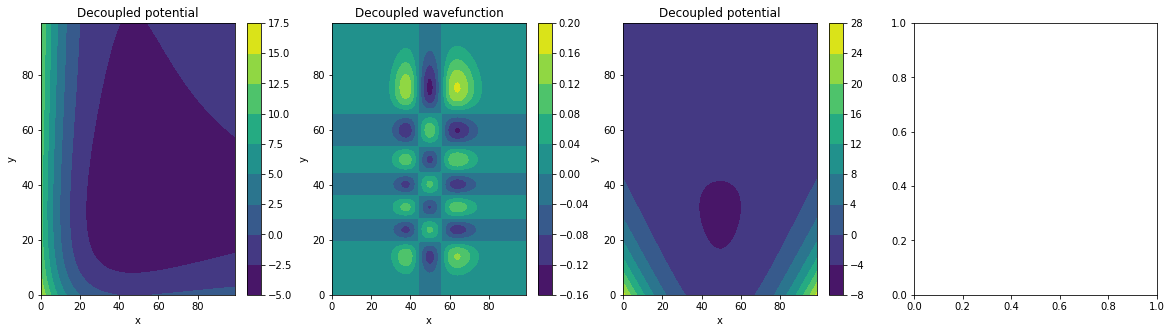

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

#cs4 = ax4.contourf(wr[idx,:,:])
#ax4.set_title("Decoupled wavefunction")
#ax4.set_xlabel("x")
#ax4.set_ylabel("y")
#fig.colorbar(cs4, ax=ax4)

plt.show()


In [ ]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)
    
    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    exp = exp/np.max(exp)
    pot = z**(lamb -n -1/2) # Potential term
    pot = pot/np.max(pot)

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    if np.isnan(laguerre).any():
      print('NAN laguerre')
      print('lambda: ', lamb)
    laguerre = laguerre/np.max(laguerre)
    phi_n = pot*exp*laguerre

    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
    
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys
  
  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -18
x_max_fit =11
y_min_fit =-5
y_max_fit =18
fit_morse = fit_coupled_morse(nx=2, ny=6, xmin=-15, xmax = 15, ymin=-7, ymax = 18)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

x_min_fit = -20
x_max_fit =22
y_min_fit =-8
y_max_fit =17

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n26/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n26/data/waves_decoupled.npy",
                   x1,"./Coupled_morse/n26/data/x_decoupled.npy" )

idx=-1

 i=2499

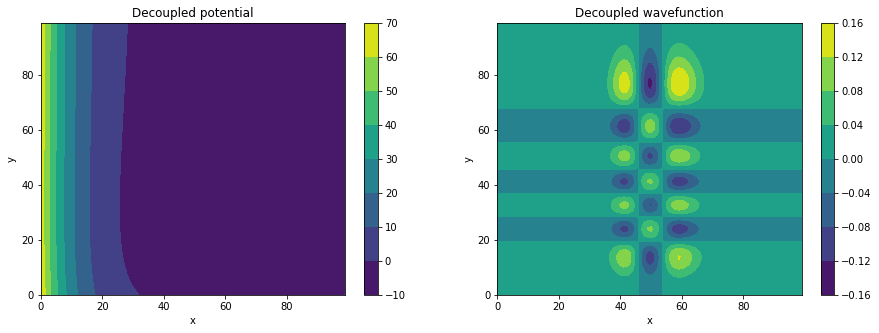

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n26/data/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n26/data/waves_all.npy", 'rb') as f:
  waves = np.load(f)



In [ ]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./Coupled_morse/n26/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n26/data/V_true.npy", 'rb') as f:
  V_real = np.load(f)
with open("./Coupled_morse/n26/data/waves_true.npy", 'rb') as f:
  waves_real = np.load(f)



## Training a neural network with Schrodinger loss

When the energy of the system increases, the eigenfunction of the Coupled morse Hamiltonian shows significant differences with respect to any of the eigenfunctions of the decoupled morse Hamiltonian. For example, the number of nodes of the wavefunction is not well-defined. In this case, training the neural network with only the decoupled wavefunction does not give optimal results. For this reason, we add a custom loss function to help training the neural network. 

Here we introduce the Scrhödinger loss function, which ensures that the wavefunction is an eigenstate of the Hamiltonian.

$$
S_{loss} = \frac{||H\hat{\psi} - \hat{E}\hat{\psi}||^2}{||\hat{\psi}||^2}
$$

Where $\hat{E}$ is the predicted mean energy, which is calculated using the input potential and the predicted wavefunction $\hat{\psi}$. Therefore the total loss function is:

$$
\mathcal{L} = MSE_d + \bar{S}_{loss_c} =  \frac{1}{N_d} \sum_{i=0}^{N_d} ||\hat{\psi^d}_i - \psi_i^d||^2 + \lambda \frac{1}{N_c} \sum_{i=0}^{N_c}\frac{||H\hat{\psi^c}_i - \hat{E}\hat{\psi^c}_i||^2}{||\hat{\psi}_i^c||^2}
$$

Where $\{\psi_i^d\}_i$ are the wavefunctions of the decoupled Hamiltonian and $\{\psi_i^c\}_i$ are the wavefunctions of the coupled Hamiltonian, and $\lambda \in \mathbb{R}$. We train the network for 300 iterations. During the first 100 iterations we set $\lambda=0$, so that the model learns to reproduce the wavefunctions of multiple decoupled Hamiltonians. Then, we choose $\lambda$ so that the two loss functions have the same order of magnitude. In this case, we set $\lambda=10^{-5}$. Notice that since the decoupled morse potential already gives a fair approximation of the true wavefunction, we do not need to put any constraints on the energy of the system. The neural network converges to the true solution, which follows the Scrhodinger equation.  



In [ ]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [ ]:
#@title Class to train the network (v2, don't run) { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    self.E = None
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    w = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    dxl, dyl = tf.image.image_gradients(w)
    dxr = tf.roll(dxl,1,axis=1)
    dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    dxx = (dxl-dxr)/(h1*h2)
    dyy = (dyl-dyr)/(h1*h2)

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,w)

    #Calculate norm
    norm = tf.reduce_sum(tf.square(w)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - self.E*w), axis=[1,2,3])
    schro_loss =mse + lamb_norm*tf.square(norm-1)

    return tf.reduce_mean(schro_loss)
  
  def get_energy(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    w = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    dxl, dyl = tf.image.image_gradients(w)
    dxr = tf.roll(dxl,1,axis=1)
    dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    dxx = (dxl-dxr)/(h1*h2)
    dyy = (dyl-dyr)/(h1*h2)

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,w)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(w,H_phi), axis = [1,2,3])

    return tf.reshape(energy, (-1,1,1,1))

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5, mu=1e-2):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
          else:
            pred_coup = self.net(x_coup)
            loss = self.schrodinger_loss(pred_coup, x_coup) + lamb*self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  def pre_train(self,  X_train_dec, y_train_dec, save=True, iters=100):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data_dec = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec))
    train_data_dec = train_data_dec.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < iters:
        for step, (batch_x_train, batch_y_train) in enumerate(train_data_dec.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path)) 

  def set_energy(self, X_train_coup):
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    phi_pred = self.net(X_train_coup)
    self.E = self.get_energy(phi_pred, X_train_coup)

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, xmin=-10, xmax=10, lamb=1e5, iters=200):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data_dec = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec))
    train_data_dec = train_data_dec.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    train_data_coup = tf.data.Dataset.from_tensor_slices((X_train_coup))
    train_data_coup = train_data_coup.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < iters:
        for step, (batch_x_train, batch_y_train) in enumerate(train_data_dec.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= X_train_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())

        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    


#conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

#train2 = Training_Scrhodinger(conv_model,learning_rate, 300, batch_size, display_step,
#                 filepath=filepath, restore=False)
#print('Pre-training')
#train2.pre_train(V_train, waves_train, save=False, iters=100)
#print('Set energy')
#X_train_coup = tf.convert_to_tensor(V_real[0:1000,:,:], dtype=tf.float32)
#phi_pred = train2.net(X_train_coup)
#train2.E = train2.get_energy(phi_pred, X_train_coup)
#print('Training')
#train2.fit(V_real[0:1000,:,:], V_train, waves_train, save=False, lamb=5e6, iters=100)

In [ ]:
#@title Class to train the network { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    w = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    dxl, dyl = tf.image.image_gradients(w)
    dxr = tf.roll(dxl,1,axis=1)
    dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    dxx = (dxl-dxr)/(h1*h2)
    dyy = (dyl-dyr)/(h1*h2)

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,w)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(w,H_phi), axis = [1,2,3])
    E = tf.reshape(energy, (-1,1,1,1))

    #Calculate norm
    norm = tf.reduce_sum(tf.square(w)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - E*w), axis=[1,2,3])
    schro_loss =mse + lamb_norm*tf.square(norm-1)

    return tf.reduce_mean(schro_loss)

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
          else:
            pred_coup = self.net(x_coup)
            loss = self.schrodinger_loss(pred_coup, x_coup) + lamb*self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, epochs_coup = 100, xmin=-10, xmax=10, lamb=1e5):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec,X_train_coup))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters:
        for step, (batch_x_train, batch_y_train, _) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        
        if epoch>epochs_coup:
          for step, (batch_x_train, batch_y_train, batch_x_coup) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= batch_x_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())

        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [ ]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train2 = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./Coupled_morse/n26/tf_ckpts/ckpt-3


In [ ]:
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 300, batch_size, display_step,
                 filepath=filepath, restore=True)
train2.fit(V_real, V_train, waves_train, save=False, lamb=5e5)

In [ ]:
save_path = train2.manager.save()
print("Saved checkpoint for step {}".format(save_path))  

Saved checkpoint for step ./Coupled_morse/n26/tf_ckpts/ckpt-3


In [ ]:
#@title Make predictions
pred = conv_model(V_real)
print("Test MAE: %f" % train2.loss(pred, waves_real))
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test MAE: 0.000106


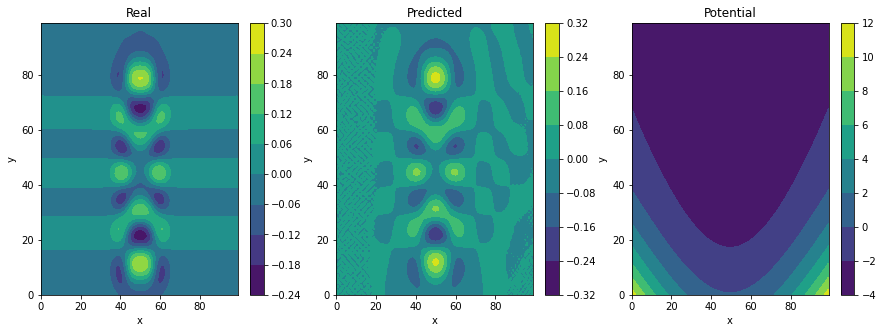

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)


cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
E = np.array([empirical_energy(waves_real[i,:,:], V_real[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])
E_emp = np.array([empirical_energy(pred[i,:], V_real[i,:,:], xmin, xmax, n_points) for i in range(pred.shape[0])])

In [ ]:
#@title Real and predicted mean energies
import plotly
from plotly.graph_objs import graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=E,
    y=E_emp,
    mode="markers", name = "empirical"))

fig.add_trace(go.Scatter(
    x=E,
    y=E,
    mode="lines", name = "theorerical"))

fig.update_layout(
    title="Morse potential energies",
    xaxis_title="Theoretical",
    yaxis_title="Empirical")

fig.show()

# Another example

## Anomalous states

In this section we are going to deal with anomalous states, that is, states where the atomic numbers are not well defined.

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

def get_min_max(data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    if len(np.where(maxima)[0])<= len(np.where(minima)[0]):
        side = np.sum(np.abs(np.where(maxima)[0]-np.where(minima)[0][:len(np.where(maxima)[0])]))<tol
    else:
        side = np.sum(np.abs(np.where(minima)[0]-np.where(maxima)[0][:len(np.where(minima)[0])]))<tol

    if np.where(maxima)[1][1] > np.where(minima)[1][1]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
        return num_min, num_max, -data, side
    return num_max, num_min, data, side

def normalize_wave(data):
    h = (xmax - xmin)/n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

def find_true_sate(waves, guesses=[28,29], true_min=11, true_max=10, tol=1):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, n_points, n_points))
    err = np.zeros(len(guesses))
    error=[]
    for i in range(n_samples):
        datas = []
        for j in range(len(guesses)):
            data = waves[guesses[j], i,:,:]
            num_max, num_min, true_data, side  = get_min_max(data)
            datas.append(true_data)
            err[j] = abs(num_max-true_max) + abs(num_min-true_min)
            if not side:
                err[j]+=4
                
        argmin_err = np.argmin(err)
        if err[argmin_err]<=tol:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
        else:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
            print("Error, no state found. i: ",  i)
            error.append(i)
    return waves_sol, err
  

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =0,
                                            xe_max = 0, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)
    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  
                                            x_min = self.xmin, x_max=self.xmax,
                                            y_min = self.ymin, y_max=self.ymax, xe_min =-0.05,
            xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 3, De_min =1)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)
    
    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    exp = exp/np.max(exp)
    pot = z**(lamb -n -1/2) # Potential term
    pot = pot/np.max(pot)

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    if np.isnan(laguerre).any():
      print('NAN laguerre')
      print('lambda: ', lamb)
    laguerre = laguerre/np.max(laguerre)
    phi_n = pot*exp*laguerre

    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
    
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys
  
  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [ ]:
  #@title Generate data { form-width: "30%" }
n_samples = 10
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -25#-19 
x_max_fit =19#19
y_min_fit =-4#-4.5
y_max_fit =15#22
fit_morse = fit_coupled_morse(nx=3, ny=2, xmin=-18, xmax = 18, ymin=-5, ymax = 15)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)


idx=-1

 i=9

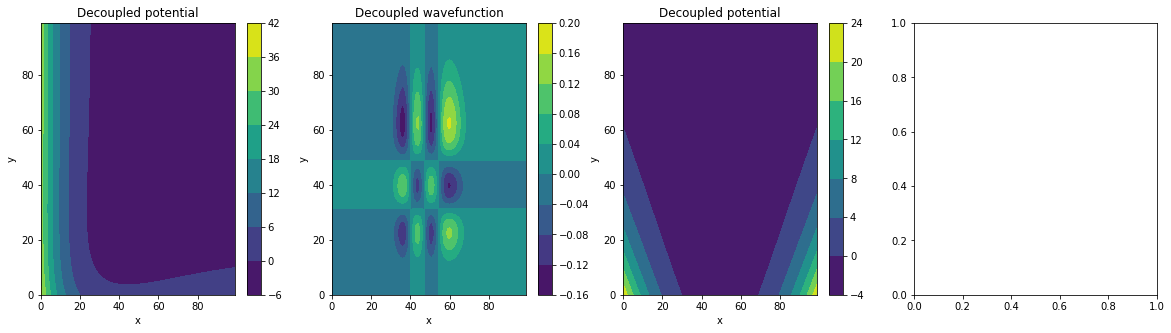

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

#cs4 = ax4.contourf(wr[idx,:,:])
#ax4.set_title("Decoupled wavefunction")
#ax4.set_xlabel("x")
#ax4.set_ylabel("y")
#fig.colorbar(cs4, ax=ax4)

plt.show()


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

xmin=-10
xmax=10
x_min_fit = -25#-19 
x_max_fit =19#19
y_min_fit =-4#-4.5
y_max_fit =15#22
fit_morse = fit_coupled_morse(nx=3, ny=2, xmin=-18, xmax = 18, ymin=-5, ymax = 15)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
x_min_fit = -20
x_max_fit =23
y_min_fit =-7
y_max_fit =14

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n23/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n23/data/waves_decoupled.npy",
                   x1,"./Coupled_morse/n23/data/x_decoupled.npy" )

idx=-1

 i=2499

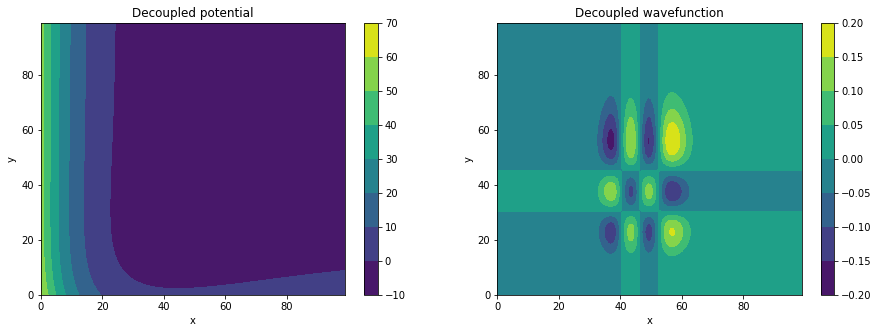

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [ ]:
# Load data
with open("./Coupled_morse/n23/data/V_decoupled.npy", 'rb') as f:
  V1 = np.load(f)
with open("./Coupled_morse/n23/data/waves_decoupled.npy", 'rb') as f:
  waves1 = np.load(f)

# Load data
with open("./Coupled_morse/n23/data/potential_true.npy", 'rb') as f:
  V2 = np.load(f)
with open("./Coupled_morse/n23/data/waves_true.npy", 'rb') as f:
  waves2 = np.load(f)
V2 = V2.reshape(-1,100,100)
V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

with open("./Coupled_morse/n23/data/waves_all.npy", 'wb') as f:
    np.save(f, waves)
with open("./Coupled_morse/n23/data/V_all.npy", 'wb') as f:
    np.save(f, V)

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n23/data/V_all.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n23/data/waves_all.npy", 'rb') as f:
  waves = np.load(f)



In [ ]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./Coupled_morse/n23/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n23/data/potential_true.npy", 'rb') as f:
  V_real = np.load(f)
with open("./Coupled_morse/n23/data/waves_true.npy", 'rb') as f:
  waves_real = np.load(f)



In [ ]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [ ]:
#@title Class to train the network { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    w = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    dxl, dyl = tf.image.image_gradients(w)
    dxr = tf.roll(dxl,1,axis=1)
    dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    dxx = (dxl-dxr)/(h1*h2)
    dyy = (dyl-dyr)/(h1*h2)

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,w)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(w,H_phi), axis = [1,2,3])
    E = tf.reshape(energy, (-1,1,1,1))

    #Calculate norm
    norm = tf.reduce_sum(tf.square(w)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - E*w), axis=[1,2,3])
    schro_loss =mse + lamb_norm*tf.square(norm-1)

    return tf.reduce_mean(schro_loss)

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
          else:
            pred_coup = self.net(x_coup)
            loss = self.schrodinger_loss(pred_coup, x_coup) + lamb*self.loss(y, pred)
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, epochs_coup = 100, xmin=-10, xmax=10, lamb=1e5):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec,X_train_coup))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters:
        for step, (batch_x_train, batch_y_train, _) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        
        if epoch>epochs_coup:
          for step, (batch_x_train, batch_y_train, batch_x_coup) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= batch_x_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())

        epoch += 1

        #Display the result
        if epoch % self.display_step == 0:
          print('Epoch: ', epoch, "Loss: ", loss.numpy())
    
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [ ]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./Coupled_morse/n26/tf_ckpts/ckpt-3


In [ ]:
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 300, batch_size, display_step,
                 filepath=filepath, restore=True)
train2.fit(V_real, V_train, waves_train, save=True, lamb=5e5)

Initializing from scratch.
Epoch:  1 Loss:  0.0002234955
Epoch:  2 Loss:  6.357545e-05
Epoch:  3 Loss:  0.0002112743
Epoch:  4 Loss:  0.00012423337
Epoch:  5 Loss:  0.00020079856
Epoch:  6 Loss:  7.0434224e-05
Epoch:  7 Loss:  7.418515e-05
Epoch:  8 Loss:  0.00016483536
Epoch:  9 Loss:  0.000100575555
Epoch:  10 Loss:  6.5161235e-05
Epoch:  11 Loss:  7.873708e-05
Epoch:  12 Loss:  1.0541979e-05
Epoch:  13 Loss:  2.8904935e-05
Epoch:  14 Loss:  0.00017722932
Epoch:  15 Loss:  9.569838e-05
Epoch:  16 Loss:  2.4969018e-05
Epoch:  17 Loss:  1.9001987e-05
Epoch:  18 Loss:  0.00011956161
Epoch:  19 Loss:  8.1914495e-06
Epoch:  20 Loss:  0.00010523243
Epoch:  21 Loss:  6.2419545e-05
Epoch:  22 Loss:  1.9062145e-05
Epoch:  23 Loss:  5.802671e-05
Epoch:  24 Loss:  5.825186e-06
Epoch:  25 Loss:  0.00013476529
Epoch:  26 Loss:  6.0667033e-05
Epoch:  27 Loss:  1.7831777e-05
Epoch:  28 Loss:  0.00011397165
Epoch:  29 Loss:  1.8655028e-05
Epoch:  30 Loss:  7.898698e-05
Epoch:  31 Loss:  0.0001310347

In [ ]:
#@title Make predictions
pred = conv_model(V_real)
print("Test MAE: %f" % train2.loss(pred, waves_real))
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Test MAE: 0.001243


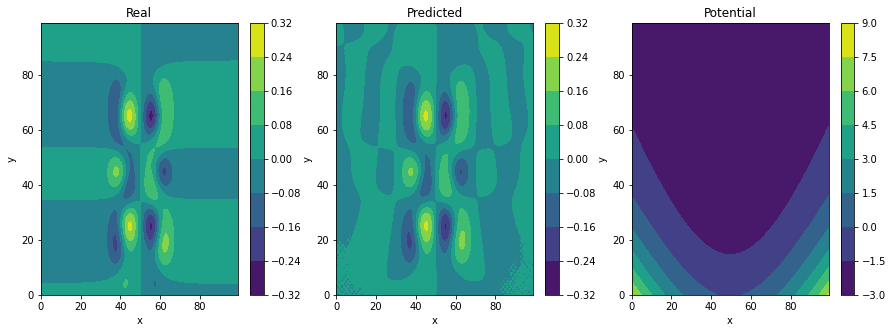

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

pred_reshape = pred.numpy().reshape(-1, n_points, n_points)


cs2 = ax2.contourf(pred_reshape[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

# Another example

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

def get_min_max(data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    if len(np.where(maxima)[0])<= len(np.where(minima)[0]):
        side = np.sum(np.abs(np.where(maxima)[0]-np.where(minima)[0][:len(np.where(maxima)[0])]))<tol
    else:
        side = np.sum(np.abs(np.where(minima)[0]-np.where(maxima)[0][:len(np.where(minima)[0])]))<tol

    if np.where(maxima)[1][1] > np.where(minima)[1][1]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
        return num_min, num_max, -data, side
    return num_max, num_min, data, side

def normalize_wave(data):
    h = (xmax - xmin)/n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

def find_true_sate(waves, guesses=[28,29], true_min=11, true_max=10, tol=1):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, n_points, n_points))
    err = np.zeros(len(guesses))
    error=[]
    for i in range(n_samples):
        datas = []
        for j in range(len(guesses)):
            data = waves[guesses[j], i,:,:]
            num_max, num_min, true_data, side  = get_min_max(data)
            datas.append(true_data)
            err[j] = abs(num_max-true_max) + abs(num_min-true_min)
            if not side:
                err[j]+=4
                
        argmin_err = np.argmin(err)
        if err[argmin_err]<=tol:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
        else:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
            print("Error, no state found. i: ",  i)
            error.append(i)
    return waves_sol, err
  

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials


    G11 = 1.05472
    G12 = 0.35 #0.01559

    morse_coupled = Coupled_Morse_potential(n_points = n_points,  x_min = self.xmin, x_max=self.xmax, y_min = self.ymin, y_max= self.ymax,
                                            xe_min =-0.01, xe_max = 0.01, a_min = 0.09, a_max = 0.10, 
                                            De_max = 9, De_min =7, G12 = G12, G11 = G11)

    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.11, a_max = 0.12, De_max = 8, De_min =7, G12 = self.G12, G11 = self.G11)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)
    
    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    exp = exp/np.max(exp)
    pot = z**(lamb -n -1/2) # Potential term
    pot = pot/np.max(pot)

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    if np.isnan(laguerre).any():
      print('NAN laguerre')
      print('lambda: ', lamb)
    laguerre = laguerre/np.max(laguerre)
    phi_n = pot*exp*laguerre

    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
    
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys
  
  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 10
n_points=100
n_state=50
n0=0

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =14
fit_morse = fit_coupled_morse(nx=13, ny=1, xmin=-10, xmax = 10, ymin=-10, ymax = 10, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)


idx=-1

 i=9

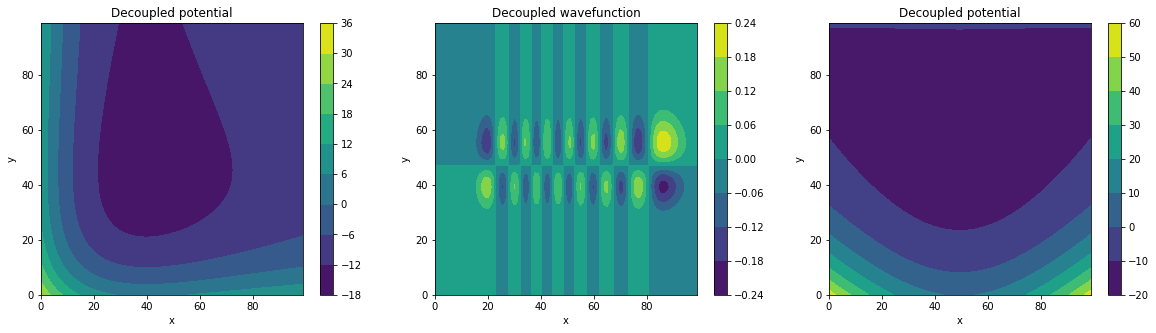

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

plt.show()


In [ ]:
E_emp = empirical_energy2D(waves1, V1, xmin=x_min_fit, xmax=x_max_fit, ymin=y_min_fit, ymax=y_max_fit, n_points=100)
mse = H_phi2D(waves1, V1, xmin=x_min_fit, xmax=x_max_fit, ymin=y_min_fit, ymax=y_max_fit, n_points=100)

print(E_emp)
print(mse)

[-11.78074387  -9.26006234 -11.2380232   -9.51517733  -9.60688217
 -12.56768475 -10.97438872 -11.87180808  -9.19949269 -10.64994339]
[17.13385762 19.10261    17.85019926 20.97041738 18.67197273 17.46603308
 17.84355809 15.91532807 20.07965015 17.55108035]


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =14
fit_morse = fit_coupled_morse(nx=13, ny=1, xmin=-8, xmax = 8, ymin=-8, ymax = 8, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
x_min_fit = -8
x_max_fit =16
y_min_fit =-10
y_max_fit =12

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)
V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n131/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n131/data/waves_decoupled.npy",
                   x1,"./Coupled_morse/n131/data/x_decoupled.npy" )

idx=-1

 i=2499

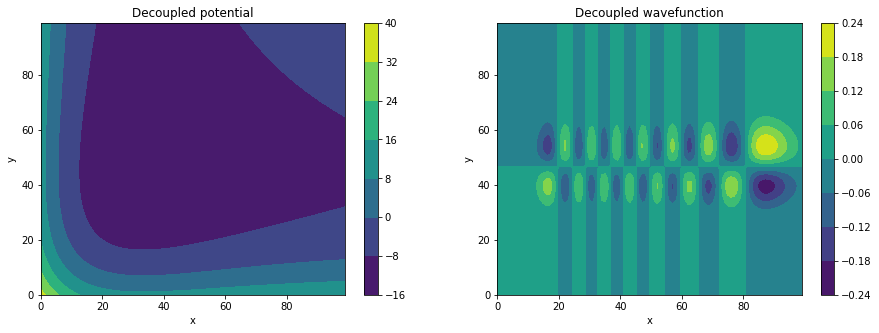

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(15,5))

cs1 = ax1.contourf(V2[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves2[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

plt.show()


In [ ]:
E_emp = empirical_energy2D(waves2, V2, xmin=x_min_fit, xmax=x_max_fit, ymin=y_min_fit, ymax=y_max_fit, n_points=100)
mse = H_phi2D(waves2, V2, xmin=x_min_fit, xmax=x_max_fit, ymin=y_min_fit, ymax=y_max_fit, n_points=100)

print(E_emp)
print(mse)

[-8.60432879 -8.4088616  -9.22490223 ... -9.47169326 -8.71244188
 -9.29872061]
[24.76863212 25.59474622 20.97304887 ... 20.0631833  23.07075894
 20.70894827]


In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n131/data/V_decoupled.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n131/data/waves_decoupled.npy", 'rb') as f:
  waves = np.load(f)



In [ ]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./Coupled_morse/n131/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n131/data/V_true.npy", 'rb') as f:
  V_real = np.load(f)
with open("./Coupled_morse/n131/data/waves_true.npy", 'rb') as f:
  waves_real = np.load(f)



In [ ]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [ ]:
#@title Class to train the network { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    #dxl, dyl = tf.image.image_gradients(phi)
    #dxr = tf.roll(dxl,1,axis=1)
    #dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    #dxx = (dxl-dxr)/(h1*h2)
    #dyy = (dyl-dyr)/(h1*h2)

    phir = tf.concat([phi[:,:,1:,:], tf.zeros((phi.shape[0],phi.shape[1],1,1))], axis=2)
    phil = tf.concat( [tf.zeros((phi.shape[0],phi.shape[1],1,1)), phi[:,:,:-1,:]], axis=2)

    dxx = (phir - 2*phi + phil)/(h1*h2) 

    phir = tf.concat([ phi[:,1:,:,:], tf.zeros((phi.shape[0],1,phi.shape[1],1))], axis=1) # We add 0 at the extrema. It makes sense because phi(x)->0 at x->+-inf
    phil = tf.concat([ tf.zeros((phi.shape[0],1,phi.shape[1],1)), phi[:,:-1,:,:]], axis=1)

    dyy = (phir - 2*phi + phil)/(h1*h2) 

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,phi)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(phi,H_phi), axis = [1,2,3])
    E = tf.reshape(energy, (-1,1,1,1))

    #Calculate norm
    norm = tf.reduce_sum(tf.square(phi)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - E*phi), axis=[1,2,3])
    #schro_loss =mse + lamb_norm*tf.square(norm-1)

    return tf.reduce_mean(mse), tf.reduce_mean(tf.square(norm-1))

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5, lamb_norm=1e4):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
            s_loss = None
            norm_loss = None
            dec_loss=loss
          else:
            pred_coup = self.net(x_coup)
            s_loss, norm_loss = self.schrodinger_loss(pred_coup, x_coup)
            dec_loss = self.loss(y, pred)
            loss = s_loss + lamb_norm*norm_loss + lamb*dec_loss
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss, s_loss, dec_loss, norm_loss

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, epochs_coup = 100, xmin=-10, xmax=10, lamb=1e5):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec,X_train_coup))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters and not stop:
        for step, (batch_x_train, batch_y_train, _) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        
        if epoch>epochs_coup:
          for step, (batch_x_train, batch_y_train, batch_x_coup) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= batch_x_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())
         #Display the result
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy(), 
                  'Scrhodinger loss: ', s_loss.numpy(), 'Decoupled loss: ', dec_loss.numpy(), 
                  'Norm loss: ', norm_loss.numpy())
        else:
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy())

        epoch += 1

           
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [ ]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


Restored from ./Coupled_morse/n131/tf_ckpts/ckpt-1


In [ ]:
 save_path = train2.manager.save()
print("Saved checkpoint for step {}".format(save_path))  

Saved checkpoint for step ./Coupled_morse/n131/tf_ckpts/ckpt-1


In [ ]:
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 400, batch_size, display_step,
                 filepath=filepath, restore=False)
train2.fit(V_real, V_train, waves_train, save=False, lamb=5e6)

Epoch:  0 Loss:  0.00010744721
Epoch:  1 Loss:  8.625745e-05
Epoch:  2 Loss:  1.5682397e-05
Epoch:  3 Loss:  6.657578e-06
Epoch:  4 Loss:  3.572753e-06
Epoch:  5 Loss:  3.4395953e-06
Epoch:  6 Loss:  4.662329e-06
Epoch:  7 Loss:  3.4613238e-06
Epoch:  8 Loss:  1.821037e-06
Epoch:  9 Loss:  3.9800684e-06
Epoch:  10 Loss:  1.4417078e-06
Epoch:  11 Loss:  1.4009411e-06
Epoch:  12 Loss:  2.5012562e-06
Epoch:  13 Loss:  8.605355e-07
Epoch:  14 Loss:  1.4355613e-06
Epoch:  15 Loss:  1.3944502e-06
Epoch:  16 Loss:  8.6422654e-07
Epoch:  17 Loss:  3.3557315e-06
Epoch:  18 Loss:  1.4036004e-06
Epoch:  19 Loss:  1.4641398e-06
Epoch:  20 Loss:  3.939178e-07
Epoch:  21 Loss:  1.3434917e-06
Epoch:  22 Loss:  5.4759613e-07
Epoch:  23 Loss:  8.2028686e-07
Epoch:  24 Loss:  1.518504e-06
Epoch:  25 Loss:  5.2184606e-07
Epoch:  26 Loss:  7.543166e-06
Epoch:  27 Loss:  5.87241e-07
Epoch:  28 Loss:  5.439404e-07
Epoch:  29 Loss:  1.0827973e-06
Epoch:  30 Loss:  4.5653331e-07
Epoch:  31 Loss:  9.807696e-07

In [ ]:
#@title Make predictions
pred = conv_model(V_real)
pred = pred.numpy().reshape(-1,100,100)
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



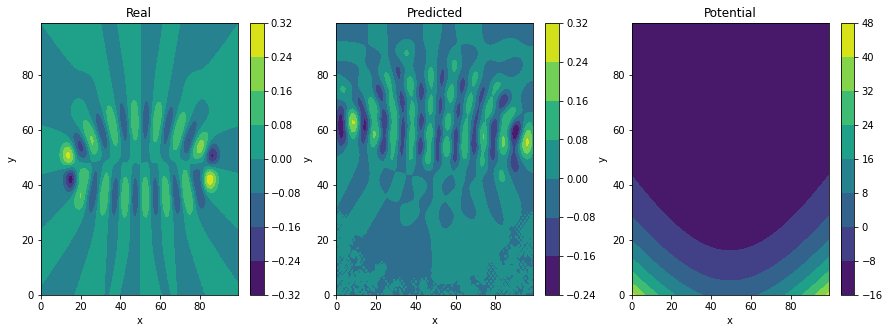

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
with open("./Figures/data/2D/V_coupled131.npy", 'wb') as f:
    np.save(f, V_real[:10,:,:])
with open("./Figures/data/2D/waves_coupled131.npy", 'wb') as f:
    np.save(f, waves_real)
with open("./Figures/data/2D/pred_coupled131.npy", 'wb') as f:
    np.save(f, pred[:10,:,:])

# Another example

In [ ]:
#@title Code to generate Coupled Morse Potentials
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial
from scipy.ndimage.filters import maximum_filter, minimum_filter


class Coupled_Morse_potential:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, G12 = 0.01559, G11 = 1.05472, m=1,
               x_min = -8, x_max=8,y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.G12 = G12
    self.G11 = G11
    self.a = np.array([None])
    self.xe = np.array([None])
    self.De = np.array([None])

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def potential1D(self, x, De, a, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    y = (x-xe)*a
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return potential
  
  def fill_alpha(self,coeff):
    aux = np.zeros((5,5))
    aux[0, :5] = coeff[:5]
    aux[1, :4] = coeff[5:9]
    aux[2, :3] = coeff[9:12]
    aux[3, :2] = coeff[12:14]
    aux[4, 0] = coeff[14]
    return aux
  
  def fit_potential(self, N, potential, n_state=0, multi=False, n0=0):
    # Prepare grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    X, Y = np.meshgrid(x, y, copy=False)
    X = X.flatten()
    Y = Y.flatten()

    # Prepare data to fit
    A = np.array([X*0+1,Y, Y**2, Y**3, Y**4,    
                  X, X*Y, X*Y**2, X*Y**3,    
                  X**2, X**2*Y, X**2*Y**2,    
                  X**3, X**3*Y,   
                  X**4]).T
    # Fit for every morse
    n_samples = potential.shape[0]
    alpha = np.zeros((n_samples,5,5))
    for i in range(n_samples):
      B = potential[i,:,:].flatten()
      coeff, r, rank, s = np.linalg.lstsq(A, B)
      alpha[i,:,:] = self.fill_alpha(coeff)
    data_gen = eigen_state_potential2D_omega(alpha, alpha, N, omega=0.1/np.sqrt(2))
    # Generate the energies, wavefunctions and potentials
    E, a, _, veps = data_gen.generate_data(n_samples, alpha, n_state)
    if multi:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax, 
                                               self.ymin,self.ymax,
                                               self.n_points, a, n_state=n_state,
                                               veps = veps, n0=n0)
    else:
      waves, x,_ = data_gen.final_wavefunction( self.xmin, self.xmax,
                                               self.ymin,self.ymax,
                                             self.n_points, a)
    return waves, alpha

  def generate_data(self, n_samples=None, n_state=0, N=32, 
                    new_a=True, get_waves = 'Single', n0=0):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(n_samples)
    
    # Grid
    x = np.linspace(self.xmin, self.xmax, self.n_points)
    y = np.linspace(self.ymin, self.ymax, self.n_points)
    q1, q2 = np.meshgrid(x, y, copy=False)

    x1_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) - q1*np.sqrt(self.G11 - self.G12))
    x2_morse = 1/np.sqrt(2)*(q2*np.sqrt(self.G11 + self.G12) + q1*np.sqrt(self.G11 - self.G12))

    # Generate x, y potential
    potential = np.zeros((n_samples, self.n_points, self.n_points))
    for i in range(n_samples):
        potential[i,:,:] = self.potential1D(x1_morse, self.De[i], self.a[i], self.xe[i]) + self.potential1D(x2_morse, self.De[i], self.a[i], self.xe[i])
    
    if get_waves=='Single':
      waves, alpha = self.fit_potential(N, potential, n_state)
    elif get_waves=='Multi':
      waves, alpha = self.fit_potential(N, potential, n_state, multi=True, n0=n0)
    else:
      waves = None
      alpha = None
    return x,y, potential, waves, alpha, self.a, self.De, self.xe

def get_min_max(data, tol=2):
    data_max = maximum_filter(data, 10)
    maxima = (data == data_max)*(data>1e-1)
    num_max = np.sum(maxima)

    data_min = minimum_filter(data, 10)
    minima = (data == data_min)*(data<-1e-1)
    num_min = np.sum(minima)
    if len(np.where(maxima)[0])<= len(np.where(minima)[0]):
        side = np.sum(np.abs(np.where(maxima)[0]-np.where(minima)[0][:len(np.where(maxima)[0])]))<tol
    else:
        side = np.sum(np.abs(np.where(minima)[0]-np.where(maxima)[0][:len(np.where(minima)[0])]))<tol

    if np.where(maxima)[1][1] > np.where(minima)[1][1]:#np.where(maxima)[0][0]<np.where(minima)[0][0]:
        return num_min, num_max, -data, side
    return num_max, num_min, data, side

def normalize_wave(data):
    h = (xmax - xmin)/n_points
    C =1./np.sqrt(np.sum(data*data*h*h))
    return C*data

def find_true_sate(waves, guesses=[28,29], true_min=11, true_max=10, tol=1):
    n_samples = waves.shape[1]
    waves_sol = np.zeros((n_samples, n_points, n_points))
    err = np.zeros(len(guesses))
    error=[]
    for i in range(n_samples):
        datas = []
        for j in range(len(guesses)):
            data = waves[guesses[j], i,:,:]
            num_max, num_min, true_data, side  = get_min_max(data)
            datas.append(true_data)
            err[j] = abs(num_max-true_max) + abs(num_min-true_min)
            if not side:
                err[j]+=4
                
        argmin_err = np.argmin(err)
        if err[argmin_err]<=tol:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
        else:
            waves_sol[i,:,:] = normalize_wave(datas[argmin_err])
            print("Error, no state found. i: ",  i)
            error.append(i)
    return waves_sol, err
  

In [ ]:
#@title Code to generate data to fit a coupled morse potential { form-width: "10%" }
#@markdown Double click to see the code

import scipy.optimize as opt


class fit_coupled_morse:

  def __init__(self, xmin=-10, xmax = 10, ymin=-10, ymax = 10, n_points = 100,
               nx = 1, ny = 2, G11 = 1.05472, G12 = 0.01559):
    self.xmin = xmin
    self.xmax = xmax
    self.ymin = ymin
    self.ymax = ymax
    self.n_points = n_points
    self.nx = nx
    self.ny = ny
    self.G11 = G11
    self.G12 = G12

  def morse_func(self, xy,Dx,ax,xe,Dy,ay,ye):
    (x,y) = xy
    return (Dx*(np.exp(-2*ax*(x-xe)) - 2*np.exp(-ax*(x-xe))) + Dy*(np.exp(-2*ay*(y-ye)) - 2*np.exp(-ay*(y-ye)))).ravel()

  def fit(self,n_samples, get_waves=False, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data with a coupled morse potential and then performs the best
    fit of two decoupled morse potentials. Then it generates data according to 
    these potentials.
    Args:
      n_samples(int): Number of samples to generate
    ''' 
    # Generate coupled morse potentials
    G11 = 1.05472
    G12 = 0.35

    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 9, De_min =7, G12 = G12, G11 = G11)

    if get_waves:
      x,y, potential,waves_tot, _, a, De, re = morse_coupled.generate_data(n_samples, n_state=n_state, N = 200, 
                                                                   new_a = True, get_waves = 'Multi', n0=n0) 

      waves_real, _ = find_true_sate(waves_tot2, guesses=[22,23,24,25,26,28], true_min=6, true_max=6, tol=4)

    
    else:
      x,y, potential,_, _, a, De, re = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 
      waves_real = None
  
    # Declare the vectors of parameters to fit
    Dex = np.zeros(n_samples)
    Dey = np.zeros(n_samples)
    ax = np.zeros(n_samples)
    ay = np.zeros(n_samples)
    xe = np.zeros(n_samples)
    ye = np.zeros(n_samples)

    # Grid to fit the data
    X, Y = np.meshgrid(x, y, copy=False)
    for i in range(n_samples):
      print("\r i={}".format(i), end="")
      # Data to fit
      initial_guess = (De[i,0], a[i,0]*np.sqrt(self.G11 - self.G12), re[i,0], De[i,0], a[i,0]*np.sqrt(self.G11 + self.G12), re[i,0])
      bounds=((0.3, 0.05, -np.inf, 0.5, 0.05, -np.inf), (np.inf, np.inf, np.inf, np.inf, 0.2, 2))
      data = potential[i,:,:].ravel()

      #Fit function
      popt, pcov = opt.curve_fit(self.morse_func, (X,Y), data, p0 = initial_guess, bounds=bounds)

      Dex[i] = popt[0]
      ax[i] = popt[1]
      xe[i] = popt[2]
      Dey[i] = popt[3]
      ay[i] = popt[4]
      ye[i] = popt[5]

    # Now generate data of the decoupled morse using the best fit of the coupled morse
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = ax
    morse.a_y = ay
    morse.De_x = Dex
    morse.De_y = Dey
    morse.xe = xe
    morse.ye = ye

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential, waves_real

  def save(self,obj, name_obj):
    with open(name_obj, 'wb') as f:
      np.save(f, obj)

  def fit_symmetric(self, n_samples, xmin_fit = -10, xmax_fit = 10,
          ymin_fit = -10, ymax_fit = 10):
    '''
    Generates data of a decoupled morse potential so that the quadratic approximation
    is equal to the one of the coupled morse potential
    Args:
      n_samples(int): Number of samples to generate
    Returns:
      V(np.array): size n_samples x n_points x n_points. Potentials of the decoupled potential
      waves(np.array): size n_samples x n_points x n_points. Wavefunctions of the decoupled potential
      x(np.array): size n_points. xrange (and yrange)
    '''
    # Generate data from the coupled morse potential
    G11 = 1.05472
    G12 = 0.35

    morse_coupled = Coupled_Morse_potential(n_points = self.n_points,  x_min = self.xmin,
                                            x_max=self.xmax, y_min=self.ymin, y_max = self.ymax, xe_min =-0.05,
                  xe_max = 0.05, a_min = 0.09, a_max = 0.1, De_max = 9, De_min =7, G12 = G12, G11 = G11)

    x, y, potential,_, _, a, De, xe = morse_coupled.generate_data(n_samples, new_a = True, get_waves = False) 

    # Generate data from the decoupled morse potential using the parameters of the coupled one
    morse = Morse2D(n_points = self.n_points,  x_min = xmin_fit, x_max=xmax_fit,
                    y_min =ymin_fit, y_max=ymax_fit)

    morse.a_x = morse_coupled.a*np.sqrt(self.G11 + self.G12)
    morse.a_y = morse_coupled.a*np.sqrt(self.G11 - self.G12)
    morse.De_x = morse_coupled.De
    morse.De_y = morse_coupled.De
    morse.xe = morse_coupled.xe
    morse.ye = morse_coupled.xe

    waves, x, y, V, _, _, _, _, _, _, nxs, nys = morse.generate_data(n_samples, new_a=False, nx=self.nx, ny=self.ny) 
    return V,waves,x,y,potential

  def save_all(self,V,name_V, waves,name_waves, x,name_x):
    self.save(V, name_V)
    self.save(waves, name_waves)
    self.save(x, name_x)

In [ ]:
#@title Class to generate Morse potential and wavefunctions
#@markdown Double click to see the code
import numpy as np
from scipy.special import eval_genlaguerre
from scipy.special import gamma, factorial

class Morse2D:

  def __init__(self, a_min = 0.05, a_max = 0.1, hbar = 1, De_min= 0.1,
               De_max = 0.5, xe_min =-5, xe_max = 5, m=1,
               x_min = -8, x_max=8, y_min = -8, y_max=8, n_points = 200):
    self.a_min = a_min # a ~ U(a_min, a_max)
    self.a_max = a_max
    self.m = m
    self.xe_min = xe_min
    self.xe_max = xe_max
    self.hbar = hbar
    self.De_min = De_min
    self.De_max = De_max
    self.xmin = x_min
    self.xmax = x_max
    self.ymin = y_min
    self.ymax = y_max
    self.n_points = n_points # Number of points of the grid 
    self.a_x=None
    self.a_y=None
    self.xe = None
    self.ye = None
    self.De_x = None
    self.De_y = None

  def generate_a(self, N):
    if N==None:
      N = 100
    self.a_x = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.a_y = np.random.uniform(self.a_min, self.a_max, N).reshape(-1,1)
    self.xe = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.ye = np.random.uniform(self.xe_min, self.xe_max, N).reshape(-1,1)
    self.De_x = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)
    self.De_y = np.random.uniform(self.De_min, self.De_max, N).reshape(-1,1)

  def order_energy(self,n_state, Dex, ax, Dey, ay):
    """
    Given omegax, omegay, we find the n_state-th excited state
    Args:
      n_state (int): Number of excited state
      omegax (float): omega in the x direction
      omegay (float): omega in the y direction
    Returns:
      (int) nx of the n_state excited state
      (int) ny of the n_state excited state
    """
    # With these omegas we create a list of the pairs (nx,ny) ordered by energy E = hbar*(omega_x*(nx+1/2) + omega_y*(ny+1/2))
    # Up to n_state (so nx,ny<= n_state), and then we order them by energy
    n = n_state+1
    nxs = np.zeros(n**2)
    nys = np.zeros(n**2)
    Es = np.zeros(n**2)
    i=0
    for nx in range(n):
      for ny in range(n): 
          nxs[i] = nx
          nys[i] = ny
          # Energy x
          lambx= np.sqrt(2*self.m*Dex)/(ax*self.hbar)
          Ex = - self.hbar*self.hbar*ax*ax/(2*self.m)*(lambx - nx-1/2)**2
          # Energy y
          lamby = np.sqrt(2*self.m*Dey)/(ay*self.hbar)
          Ey = - self.hbar*self.hbar*ay*ay/(2*self.m)*(lamby - ny-1/2)**2
          Es[i] = Ex + Ey
          i+=1
    
    idxs = np.argsort(Es)
    nxs = nxs[idxs]
    nys = nys[idxs]
    return int(nxs[n_state]), int(nys[n_state])


  def morse_wavefunction(self,x,n, a, De, xe):
    """
    Returns the morse 1D wavefunction
    Args:
      N (int): Number of samples
      n (int): Energetic level
      a (np.array): Values of a for every sample
      De (np.array): Values of De for every sample
    """
    
    # Calculate lambda parameter
    lamb = np.sqrt(2*self.m*De)/(a*self.hbar)
    
    y = (x-xe)*a
    z = 2*lamb*np.exp(-y)
    # Calculate terms of the wavefunction
    exp = np.exp(-1/2*z) #exponential term
    exp = exp/np.max(exp)
    pot = z**(lamb -n -1/2) # Potential term
    pot = pot/np.max(pot)

    laguerre = eval_genlaguerre(n, 2*lamb - 2*n -1, z)
    if np.isnan(laguerre).any():
      print('NAN laguerre')
      print('lambda: ', lamb)
    laguerre = laguerre/np.max(laguerre)
    phi_n = pot*exp*laguerre

    # Finally, calculate the potential
    potential = De*(np.exp(-2*y) - 2*np.exp(-y))

    return phi_n, potential, x

  def generate_data(self, N=None, n=0, new_a=True, nx=None, ny=None):
    '''
    Generates N random data points from the energetic level n
    '''
    if new_a:
      self.generate_a(N)

    # Generate x and y wavefunctions
    potential_x = np.zeros((N,self.n_points))
    potential_y = np.zeros((N,self.n_points))
    phi_x = np.zeros((N,self.n_points))
    phi_y = np.zeros((N,self.n_points))
    nxs = np.zeros(N)
    nys = np.zeros(N)
    # Create grid
    x = np.arange(self.xmin, self.xmax, (self.xmax - self.xmin)/self.n_points) # Grid of x values
    y = np.arange(self.ymin, self.ymax, (self.ymax - self.ymin)/self.n_points) # Grid of x values

    for sample in range(N): 
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, self.De_x[sample], self.a_x[sample],self.De_y[sample], self.a_y[sample])
      p_x, pot_x, _ =  self.morse_wavefunction(x,nx, self.a_x[sample], self.De_x[sample], self.xe[sample])
      p_y, pot_y, _ =  self.morse_wavefunction(y,ny, self.a_y[sample], self.De_y[sample], self.ye[sample])
      phi_x[sample,:] = p_x
      phi_y[sample,:] = p_y
      potential_x[sample,:] = pot_x
      potential_y[sample,:] = pot_y
      nxs[sample] = nx
      nys[sample] = ny

    # Declare the vectors of potential and phi
    phi = np.zeros((N, self.n_points, self.n_points))
    potential = np.zeros((N, self.n_points, self.n_points))
    ones = np.repeat(1,self.n_points)
    h1 = (self.xmax - self.xmin)/self.n_points
    h2 = (self.ymax - self.ymin)/self.n_points

    for i in range(N):
        phi_xi = np.tensordot(phi_x[i,:], ones, axes=0).T
        phi_yi = np.tensordot(phi_y[i,:], ones, axes=0)
        phi_i = phi_xi*phi_yi #np.outer(phi_x[i,:], phi_y[i,:].T)
        C = 1./np.sqrt(np.sum(phi_i*phi_i*h1*h2)) # Normalization constant
        phi[i,:,:] = C*phi_i
        # Potential
        pot_x = np.tensordot(potential_x[i,:], ones, axes=0).T
        pot_y = np.tensordot(potential_y[i,:], ones, axes=0)
        potential[i,:,:] = pot_x + pot_y
    
    return phi, x,y,potential, self.a_x, self.a_y, self.De_x, self.De_y, self.xe, self.ye, nxs, nys
  
  def get_energy(self, n,nx = None, ny=None, a_x = None, De_x = None, a_y = None, De_y = None):
    if (a_x==None).any():
      a_x = self.a_x
    if (De_x==None).any():
      De_x = self.De_x
    if (a_y==None).any():
      a_y = self.a_y
    if (De_y==None).any():
      De_y = self.De_y

    N = a_x.shape[0]
    E = np.zeros(N)
    for i in range(N):
      if nx==None or ny==None:
        nx, ny = self.order_energy(n, De_x[i], a_x[i],De_y[i], a_y[i])
      #Energy x
      lambx = np.sqrt(2*self.m*De_x[i])/(a_x[i]*self.hbar)
      Ex = - self.hbar*self.hbar*a_x[i]**2/(2*self.m)*(lambx - nx-1/2)**2
      #Energy y
      lamby = np.sqrt(2*self.m*De_y[i])/(a_y[i]*self.hbar)
      Ey = - self.hbar*self.hbar*a_y[i]**2/(2*self.m)*(lamby - ny-1/2)**2
      E[i] = Ex + Ey
    return E


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 10
n_points=100
n_state=50
n0=0
G11 = 1.05472
G12 = 0.25 #0.01559

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =20
fit_morse = fit_coupled_morse(nx=10, ny=10, xmin=-10, xmax = 10, ymin=-10, ymax = 10, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)


idx=-1

 i=9

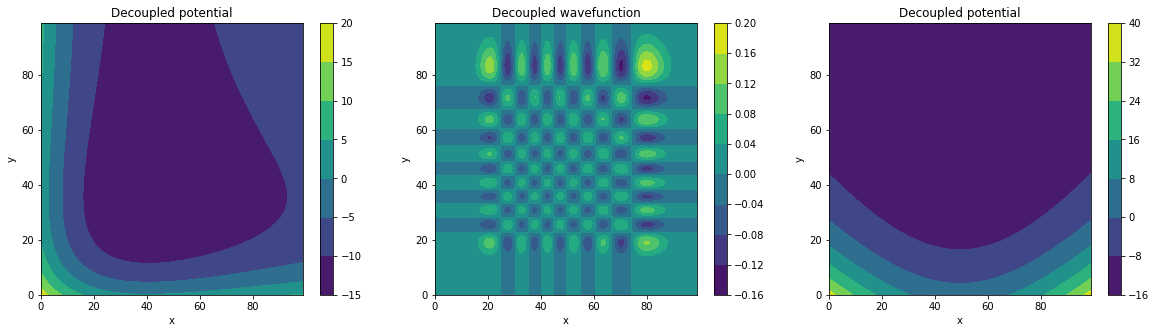

In [ ]:
#@title Example potential and wavefunction
import matplotlib.pyplot as plt
idx+=1
fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(20,5))

cs1 = ax1.contourf(V1[idx,:,:])
ax1.set_title("Decoupled potential")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
fig.colorbar(cs1, ax=ax1)

cs2 = ax2.contourf(waves1[idx,:,:])
ax2.set_title("Decoupled wavefunction")
ax2.set_xlabel("x")
ax2.set_ylabel("y")
fig.colorbar(cs2, ax=ax2)

cs3 = ax3.contourf(pot1[idx,:,:])
ax3.set_title("Decoupled potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
fig.colorbar(cs3, ax=ax3)

plt.show()


In [ ]:
#@title Generate data { form-width: "30%" }
n_samples = 2500
n_points=100
n_state=50
n0=0
G11 = 1.05472
G12 = 0.25 #0.01559

x_min_fit = -12
x_max_fit =12
y_min_fit =-8
y_max_fit =20
fit_morse = fit_coupled_morse(nx=10, ny=10, xmin=-10, xmax = 10, ymin=-10, ymax = 10, G11 = G11, G12 = G12)
V1,waves1,x1, y2, pot1, wr = fit_morse.fit(n_samples, get_waves = False,
                                           xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

x_min_fit = -10
x_max_fit =16
y_min_fit =-9
y_max_fit =17

V2,waves2,x1, y2, pot2 = fit_morse.fit_symmetric(n_samples, xmin_fit = x_min_fit, xmax_fit = x_max_fit,
                                           ymin_fit = y_min_fit, ymax_fit = y_max_fit)

V = np.concatenate((V1,V2), axis=0)
waves = np.concatenate((waves1, waves2), axis=0)

fit_morse.save_all(V, "./Coupled_morse/n1010/data/V_decoupled.npy",
                   waves,"./Coupled_morse/n1010/data/waves_decoupled.npy",
                   x1,"./Coupled_morse/n1010/data/x_decoupled.npy" )

idx=-1

 i=2499

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n1010/data/V_decoupled.npy", 'rb') as f:
  V = np.load(f)
with open("./Coupled_morse/n1010/data/waves_decoupled.npy", 'rb') as f:
  waves = np.load(f)



In [ ]:
#@title Parameters to train the neural network { output-height: 10 }

#@markdown ---
#@markdown ### Enter the training parameters:
n_points = 100#@param {type:"integer"}
learning_rate = 0.0005#@param {type:"number"}
training_iters =  350#@param {type:"integer"}
batch_size = 64#@param {type:"integer"}
display_step = 1#@param {type:"integer"}
filepath =  "./Coupled_morse/n1010/tf_ckpts/" #@param {type:"string"}
#@markdown ---

#@markdown ---
#@markdown ### Enter the network parameters:
n1 = 64#@param {type:"integer"}
n2= 64#@param {type:"integer"}
n3=32#@param {type:"integer"}
n4=32#@param {type:"integer"}
nfc = 128#@param {type:"integer"}
drop=0.2#@param {type:"number"}
#@markdown ---



## Load test data

In [ ]:
#@title Load data
# Load data
with open("./Coupled_morse/n1010/data/V_true.npy", 'rb') as f:
  V_real = np.load(f)
with open("./Coupled_morse/n1010/data/waves_true.npy", 'rb') as f:
  waves_real = np.load(f)



In [ ]:
#@title Class to define the neural network
#@markdown Double click to see the code

import tensorflow as tf
from tensorflow.keras import Model, layers
class Conv_Model2D(tf.keras.Model):
    '''
    Subclassed keras tf.keras.Model API. The input will be the potential V(x)
    and the output will be the wave function phi_n(x).
    Args:
      input_size (int): Number of x points
    Attributes:
      input_size (int): Number of x points
      fc1 (layer): First  fully cinnected layer with 512 filters and relu activation function
      dropout1 (layer): Dropout layer with dropout parameter of 0.2
      fc2 (layer): Second  fully cinnected layer with 256 filters and relu activation function
      dropout2 (layer): Dropout layer with dropout parameter of 0.2
      fc3 (layer): Third  fully cinnected layer with 256 filters and relu activation function
      dropout3 (layer): Dropout layer with dropout parameter of 0.2
      fc4 (layer): Fourth  fully cinnected layer with 128 filters and relu activation function
      dropout4 (layer): Dropout layer with dropout parameter of 0.2
      out (layer): Output layer predicting phi_n(x)
    '''
    def __init__(self,
                 name='fc_model', input_size=100,
                 n1 = 64, n2= 64, n3=128, n4=128, nfc=128, drop=0.2,
                 **kwargs):
        self.input_size = input_size
        self.shape_input = (input_size, input_size,1)
        super(Conv_Model2D, self).__init__(name=name, **kwargs)

        # Convolution Layer 
        self.conv1 = layers.Conv2D(filters=n1, kernel_size = 3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same',
                                   input_shape = self.shape_input)
        # Max Pooling (down-sampling)
        self.maxpool1 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout1= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv2 = layers.Conv2D(filters=n2, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool2 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout2= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv3 = layers.Conv2D(filters=n3, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool3 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout3= tf.keras.layers.Dropout(drop)

        # Convolution Layer 
        self.conv4 = layers.Conv2D(filters=n4, kernel_size =3, strides=(2, 2),
                                   activation=tf.nn.relu, padding='same')
        # Max Pooling (down-sampling)
        self.maxpool4 = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='same')
        self.dropout4= tf.keras.layers.Dropout(drop)

        # Flatten the data to a 1-D vector for the fully connected layer.
        self.flatten = layers.Flatten()

        # Fully connected layer.
        self.fc1 = layers.Dense(nfc, activation=tf.nn.relu)
        # Apply Dropout (if is_training is False, dropout is not applied).
        self.dropoutfc1 = layers.Dropout(rate=drop)

        # Fully connected layer.
        self.fc2 = layers.Dense(nfc, activation=tf.nn.relu)

        # Output layer (fully connected with input_size neurons and linear activation function )
        self.out = tf.keras.layers.Dense(input_size*input_size, activation ='linear')


    @tf.function
    def call(self, inputs, is_training=False):
        '''
        Forward pass of the fully connected model

        Args:
          inputs (tensor): X data to pass through the network (V(x))
          is_training (bool): If training, True, otherwise, False
        
        Returns:
          out (tensor): Output tensor containing the values of phi_n(x)
        '''
        x = tf.reshape(inputs, tf.constant([-1, self.input_size, self.input_size, 1]))
        x = self.conv1(x)
        x = self.maxpool1(x)
        x = self.dropout1(x, training=is_training)
        x = self.conv2(x)
        x = self.maxpool2(x)
        x = self.dropout2(x, training=is_training)
        x = self.conv3(x)
        x = self.maxpool3(x)
        x = self.dropout3(x, training=is_training)
        x = self.conv4(x)
        x = self.maxpool4(x)
        x = self.dropout4(x, training=is_training)
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.dropoutfc1(x, training=is_training)
        x = self.fc2(x)
        out = self.out(x)
        return out


In [ ]:
#@title Class to train the network { form-width: "20%" }
#@markdown Double click to see the code
class Training_Scrhodinger():
  '''
  Performs the training of the autoencoder model using mean absolute error loss

  Args:
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them

  Attributes: 
    net (Model): Model to train
    learning_rate (float): Learning Rate for Adam optimizer
    training_iters (int): Numer of training iterations
    batch_size (int): Batch size
    display_step (int): Number of iterations to wait to print the current performance of the model
    stopping_step (int): How many epochs we have waited so far without the validation loss decreasing
    early_stopping (int): Number of epochs to wait for the validation loss to increase before performing early stopping
    filepath (str): File path to store and recover the model weights
    restore (bool): If true, it looks for existing weights to reestore them
    loss (function): Loss function to optimize. In this case, mean square error
    optimizer (tf.Optimizer): Adam optimizer for the learning steps
    ckpt (tf.Checkpoint): Checkpoint that stores weights and optimizer state
    manager (tf.CheckpointManager): Controls that not too many checkpoint files are stored 
    

  '''

  def __init__(self, net, learning_rate, training_iters, batch_size, display_step, 
               early_stopping=50, filepath=None, restore =True):
    self.net = net
    self.learning_rate = learning_rate
    self.training_iters = training_iters
    self.batch_size = batch_size
    self.display_step = display_step
    self.stopping_step=0
    self.best_loss=100
    self.early_stopping = early_stopping
    self.optimizer = tf.keras.optimizers.Adam(self.learning_rate)
    self.filepath = filepath
    self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, net=self.net)
    self.manager = tf.train.CheckpointManager(self.ckpt, directory = filepath , max_to_keep=3)
    if restore:
      self.ckpt.restore(self.manager.latest_checkpoint)
      if self.manager.latest_checkpoint:
          print("Restored from {}".format(self.manager.latest_checkpoint))
      else:
          print("Initializing from scratch.")

  def loss(self, y_true, y_pred):
    y_true = tf.convert_to_tensor(y_true)
    y_true_reshaped = tf.reshape(y_true, y_pred.shape)
    return tf.reduce_mean(tf.square(tf.subtract(y_true_reshaped, y_pred)))

  def schrodinger_loss(self, phi, potential,xmin=-10, xmax=10, ymin=-10, ymax=10, lamb_norm=1e3):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = tf.reshape(phi, shape= (-1,n_points, n_points, 1))
    V = tf.reshape(potential, shape = (-1,n_points, n_points, 1))

    # Calculate first differences
    #dxl, dyl = tf.image.image_gradients(phi)
    #dxr = tf.roll(dxl,1,axis=1)
    #dyr = tf.roll(dyl,1,axis=2)
    # Calculate second differences
    #dxx = (dxl-dxr)/(h1*h2)
    #dyy = (dyl-dyr)/(h1*h2)

    phir = tf.concat([phi[:,:,1:,:], tf.zeros((phi.shape[0],phi.shape[1],1,1))], axis=2)
    phil = tf.concat( [tf.zeros((phi.shape[0],phi.shape[1],1,1)), phi[:,:,:-1,:]], axis=2)

    dxx = (phir - 2*phi + phil)/(h1*h2) 

    phir = tf.concat([ phi[:,1:,:,:], tf.zeros((phi.shape[0],1,phi.shape[1],1))], axis=1) # We add 0 at the extrema. It makes sense because phi(x)->0 at x->+-inf
    phil = tf.concat([ tf.zeros((phi.shape[0],1,phi.shape[1],1)), phi[:,:-1,:,:]], axis=1)

    dyy = (phir - 2*phi + phil)/(h1*h2) 

    #Calculate Scrhödinger loss
    H_phi = -1./2*(dxx + dyy) + tf.math.multiply(V,phi)

    # Approximate energy
    energy = tf.reduce_sum(h1*h2*tf.math.multiply(phi,H_phi), axis = [1,2,3])
    E = tf.reshape(energy, (-1,1,1,1))

    #Calculate norm
    norm = tf.reduce_sum(tf.square(phi)*h1*h2, axis=[1,2,3])

    mse = tf.reduce_sum(tf.square(H_phi - E*phi), axis=[1,2,3])

    return tf.reduce_mean(mse), tf.reduce_mean(tf.square(norm-1))

  @tf.function()
  def run_optimization(self,x,y,x_coup=None, dec=False, lamb=1e5, lamb_norm=1e4):
      '''
      Performs one step of the learning process. It calculates the loss function and
      appies backpropagation algorithm to update the weights.

      Args:
        x (tensor): Samples of training data used to train the model
      
      Returns:
        -
      '''
      # Wrap computation inside a GradientTape for automatic differentiation.
      with tf.GradientTape() as g:
          # Forward pass.
          pred = self.net(x)
          # Compute loss.
          if dec:
            loss = self.loss(y, pred)
            s_loss = None
            norm_loss = None
            dec_loss=loss
          else:
            pred_coup = self.net(x_coup)
            s_loss, norm_loss = self.schrodinger_loss(pred_coup, x_coup)
            dec_loss = self.loss(y, pred)
            loss = s_loss + lamb_norm*norm_loss + lamb*dec_loss
          
      # Variables to update, i.e. trainable variables.
      trainable_variables = self.net.trainable_variables

      # Compute gradients.
      gradients = g.gradient(loss, trainable_variables)
      
      # Update W and b following gradients.
      self.optimizer.apply_gradients(zip(gradients, trainable_variables))
      return loss, s_loss, dec_loss, norm_loss

  #@tf.function
  def fit(self, X_train_coup, X_train_dec, y_train_dec, 
          save=True, epochs_coup = 100, xmin=-10, xmax=10, lamb=1e5):
    '''
    Main fit function 

    Args:
      X_train (numpy array): Processed training data (wavefunctions)
      X_test (numpy array): Processed test data (wavefunctions)
      save (bool): If true, we save the weights at the end of the training
    Returns:
      -
    '''
    # Create train and test datasets
    # Use tf.data API to shuffle and batch data.
    X_train_coup = tf.convert_to_tensor(X_train_coup, dtype=tf.float32)
    X_train_dec = tf.convert_to_tensor(X_train_dec, dtype=tf.float32)
    y_train_dec = tf.convert_to_tensor(y_train_dec, dtype=tf.float32)

    train_data = tf.data.Dataset.from_tensor_slices((X_train_dec, y_train_dec,X_train_coup))
    train_data = train_data.repeat().shuffle(5000).batch(self.batch_size).prefetch(1)

    loss_batch = []
    val_loss_batch = []

    stop = False
    epoch = 0
    
    # Run training for the given number of steps (and while not early stopping).
    while epoch < self.training_iters:
        for step, (batch_x_train, batch_y_train, _) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, dec=True)
            loss_batch.append(loss.numpy())
        
        if epoch>epochs_coup:
          for step, (batch_x_train, batch_y_train, batch_x_coup) in enumerate(train_data.take(self.training_iters), 1):
            #Apply backpropagation algorithm
            loss, s_loss, dec_loss, norm_loss = self.run_optimization(batch_x_train, batch_y_train, x_coup= batch_x_coup, dec=False, lamb=lamb)
            loss_batch.append(loss.numpy())
         #Display the result
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy(), 
                  'Scrhodinger loss: ', s_loss.numpy(), 'Decoupled loss: ', dec_loss.numpy(), 
                  'Norm loss: ', norm_loss.numpy())
        else:
          if epoch % self.display_step == 0:
            print('Epoch: ', epoch, "Loss: ", loss.numpy())

        epoch += 1

           
    #Save the weights
    if save:
      save_path = self.manager.save()
      print("Saved checkpoint for step {}".format(save_path))    

In [ ]:
import random

from sklearn.model_selection import train_test_split

# Split train and test 
V_train, V_test, waves_train, waves_test = train_test_split(V, waves, train_size=V_real.shape[0], random_state=123)


In [ ]:
#@title Run to load model { form-width: "30%" }
conv_model = Conv_Model2D(input_size=n_points,n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)
train = Training_Scrhodinger(conv_model,learning_rate, training_iters, batch_size,
                 display_step, filepath=filepath, early_stopping=100, restore=True)


In [ ]:
conv_model = Conv_Model2D(input_size=n_points, n1=n1, n2=n2, n3=n3, n4=n4, nfc = nfc, drop=drop)

train2 = Training_Scrhodinger(conv_model,learning_rate, 400, batch_size, display_step,
                 filepath=filepath, restore=False)
train2.fit(V_real, V_train, waves_train, save=True, lamb=5e6)

Epoch:  0 Loss:  0.00016642494
Epoch:  1 Loss:  4.2002357e-05
Epoch:  2 Loss:  1.2157444e-05
Epoch:  3 Loss:  8.696592e-06
Epoch:  4 Loss:  8.063842e-06
Epoch:  5 Loss:  1.6112015e-05
Epoch:  6 Loss:  6.506647e-06
Epoch:  7 Loss:  1.079769e-05
Epoch:  8 Loss:  5.5334835e-06
Epoch:  9 Loss:  5.1674438e-06
Epoch:  10 Loss:  6.0272446e-06
Epoch:  11 Loss:  5.88006e-06
Epoch:  12 Loss:  5.4778693e-06
Epoch:  13 Loss:  5.3737413e-06
Epoch:  14 Loss:  2.6354164e-06
Epoch:  15 Loss:  4.8677334e-06
Epoch:  16 Loss:  2.8340846e-06
Epoch:  17 Loss:  3.975432e-06
Epoch:  18 Loss:  3.3051406e-06
Epoch:  19 Loss:  2.122115e-06
Epoch:  20 Loss:  2.7880524e-06
Epoch:  21 Loss:  2.206381e-06
Epoch:  22 Loss:  3.0927172e-06
Epoch:  23 Loss:  1.6928155e-06
Epoch:  24 Loss:  1.2543354e-06
Epoch:  25 Loss:  3.3776375e-06
Epoch:  26 Loss:  1.834143e-06
Epoch:  27 Loss:  1.9721415e-06
Epoch:  28 Loss:  1.5890265e-06
Epoch:  29 Loss:  8.994767e-07
Epoch:  30 Loss:  1.1453957e-06
Epoch:  31 Loss:  3.93345e-06

In [ ]:
#@title Make predictions
pred = conv_model(V_real)
pred = pred.numpy().reshape(-1,100,100)
idx=-1


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



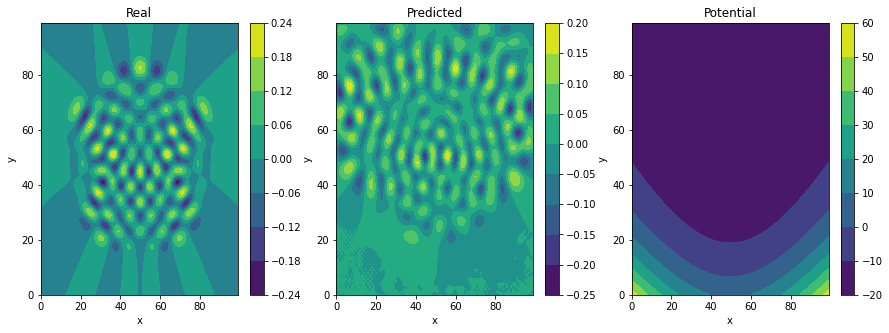

In [ ]:
#@title Real and predicted wavefunctions
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

idx +=1
fig, (ax1, ax2,ax3) = plt.subplots(1, 3,figsize=(15,5))


cs1 = ax1.contourf(waves_real[idx,:,:])
ax1.set_title("Real")
ax1.set_xlabel("x")
ax1.set_ylabel("y")

cs2 = ax2.contourf(pred[idx,:,:] )
ax2.set_title("Predicted")
ax2.set_xlabel("x")
ax2.set_ylabel("y")

V_real = V_real.reshape(-1,n_points,n_points)
cs3 = ax3.contourf(V_real[idx,:,:])
ax3.set_title("Potential")
ax3.set_xlabel("x")
ax3.set_ylabel("y")

cbar1 = fig.colorbar(cs1, ax=ax1)
cbar2 = fig.colorbar(cs2, ax=ax2)
cbar3 = fig.colorbar(cs3, ax=ax3)
plt.show()

In [ ]:
#@title Code to calculate the empirical energy
#@markdown Double click to show code

def empirical_energy1D( phi, potential, xmin=-8, xmax = 8,
                       n_points=200, hbar=1, m=1):
    # Normalize phi just in case
    h = (xmax - xmin)/n_points

    def energy(phi,potential,h):
      C = 1./np.sqrt(np.sum(phi*phi*h))
      phi = C*phi
      # We first calculate the second derivative of phi
      phir = np.concatenate(( phi[1:], np.zeros(1)), axis=0) # We add 0 at the extrema. It makes sense because phi(x)->0 at x->+-inf
      phil = np.concatenate(( np.zeros(1), phi[:-1]), axis=0)
      
      deriv = (phir - 2*phi + phil)/(h*h)
      return np.sum((-hbar*hbar/(2*m)*phi*deriv + potential*(phi*phi))*h)

    E = np.array([energy(phi[i,:], potential[i,:], h) for i in range(phi.shape[0])])   
    return E

def empirical_energy2D(phi, potential, xmin=-10, xmax = 10,
                       ymin=-10, ymax = 10,
                       n_points=100, hbar=1, m=1):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = np.asarray(phi)
    if phi.shape!= potential.shape:
      phi = np.reshape(phi, potential.shape)

    # We first calculate the second derivative of phi
    # derivative x
    phir = phi.copy()
    phir[:,:,0] = 0
    phir[:,:,1:] = phi[:,:,:-1]
    phil = phi.copy()
    phil[:,:,-1] = 0
    phil[:,:,:-1] = phi[:,:,1:]
    deriv_x = (phir - 2*phi + phil)/(h1*h2)

    # derivative y
    phir = phi.copy()
    phir[:,0,:] = 0
    phir[:,1:,:] = phi[:,:-1,:]
    phil = phi.copy()
    phil[:,-1,:] = 0
    phil[:,:-1,:] = phi[:,1:,:]
    deriv_y = (phir - 2*phi + phil)/(h1*h2)

    # Now we calculate the mean energy
    energy = np.sum((-hbar*hbar/(2*m)*phi*(deriv_x + deriv_y) + potential*(phi*phi))*h1*h2, axis=(1,2))
    return energy

def H_phi2D(phi, potential, xmin=-10, xmax = 10,
                       ymin=-10, ymax = 10,
                       n_points=100, hbar=1, m=1):
    h1 = (xmax - xmin)/n_points
    h2 = (ymax - ymin)/n_points
    phi = np.asarray(phi)
    if phi.shape!= potential.shape:
      phi = np.reshape(phi, potential.shape)

    # We first calculate the second derivative of phi
    # derivative x
    phir = phi.copy()
    phir[:,:,0] = 0
    phir[:,:,1:] = phi[:,:,:-1]
    phil = phi.copy()
    phil[:,:,-1] = 0
    phil[:,:,:-1] = phi[:,:,1:]
    deriv_x = (phir - 2*phi + phil)/(h1*h2)

    # derivative y
    phir = phi.copy()
    phir[:,0,:] = 0
    phir[:,1:,:] = phi[:,:-1,:]
    phil = phi.copy()
    phil[:,-1,:] = 0
    phil[:,:-1,:] = phi[:,1:,:]
    deriv_y = (phir - 2*phi + phil)/(h1*h2)

    # Now we calculate the mean energy
    energy = np.sum((-hbar*hbar/(2*m)*phi*(deriv_x + deriv_y) + potential*(phi*phi))*h1*h2, axis=(1,2))
    energy = energy.reshape(-1,1,1)

    H_phi = -hbar*hbar/(2*m)*(deriv_x + deriv_y) + potential*phi
    mse = np.sum(np.abs(H_phi - energy*phi), axis=(1,2))
    return mse

In [ ]:
with open("./Figures/data/2D/V_coupled1010.npy", 'wb') as f:
    np.save(f, V_real)
with open("./Figures/data/2D/waves_coupled1010.npy", 'wb') as f:
    np.save(f, waves_real)
with open("./Figures/data/2D/pred_coupled1010.npy", 'wb') as f:
    np.save(f, pred)